<a href="https://colab.research.google.com/github/eterniacockers/BASH-Risk/blob/main/ATL_Full_Feature_set_Three_hour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by uploading the imputed data file.

In [ ]:
from google.colab import files
import pandas as pd

# Upload file
uploaded = files.upload()

# Read Excel file
file_name = list(uploaded.keys())[0]  # Get uploaded filename
df = pd.read_excel(file_name)


Saving ATL_Data_Python_Imputed.xlsx to ATL_Data_Python_Imputed.xlsx


Encode data, remove excess features and prepare for the different ensemble models.

In [ ]:
# Step 1.1 Preprocessing: Initial cleaning and encoding
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_excel("ATL_Data_Python_Imputed.xlsx")

# Convert date column to datetime and sort by date
df['DATE_and_Time'] = pd.to_datetime(df['DATE_and_Time'])
df.sort_values(by='DATE_and_Time', inplace=True)

# Quartile transformation for Max_Risk (Used ONLY for XGBoost)
df['Max_Risk_Quartile'] = pd.qcut(df['Max_Risk'].rank(method="first"), q=4, labels=False)


# Normalize numerical features BEFORE lagging
numeric_vars = ["Altimeter", "Precipitation", "Humidity",
                "Visibility", "Wet_Bulb", "Wind_Speed",
                "Wind_Direction"]
scaler = MinMaxScaler()
df[numeric_vars] = scaler.fit_transform(df[numeric_vars])

categorical_vars = ["Sky_Cond"]

# One-hot encode Risk (Only needed for lagging step, will remove later)
df = pd.get_dummies(df, columns=["Risk","Sky_Cond"], drop_first=False)

# Create a single categorical target column for LSTM (0 = Low, 1 = Moderate, 2 = Severe)
risk_mapping = {"Low": 0, "Moderate": 1, "Severe": 2}
df['Risk_Category'] = df[['Risk_Low', 'Risk_Moderate', 'Risk_Severe']].idxmax(axis=1).map(lambda x: risk_mapping[x.replace("Risk_", "")])

# Drop unnecessary columns (Exclude `Max_Risk_Quartile` for LSTM, Exclude `Risk_Category` and one-hot Risk for XGBoost)
df.drop(columns=["Station", "4_hr_Precip", "4_hr_Sky_Cond",
                 "10_Day_Precip", "Max_Risk"], inplace=True)

# Display verification
print("Step 1.1 Completed. Sample rows:")
print(df.head())

# Save preprocessed data for verification before feature engineering
df.to_csv("ATL_Preprocessed_All.csv", index=False)

from google.colab import files

# download file
files.download("ATL_Preprocessed_All.csv")


Step 1.1 Completed. Sample rows:
        DATE_and_Time  Altimeter  Precipitation  Humidity  Visibility  \
0 2015-01-01 00:00:00   0.766234            0.0  0.703297         1.0   
1 2015-01-01 01:00:00   0.772727            0.0  0.725275         1.0   
2 2015-01-01 02:00:00   0.766234            0.0  0.736264         1.0   
3 2015-01-01 03:00:00   0.753247            0.0  0.670330         1.0   
4 2015-01-01 04:00:00   0.746753            0.0  0.725275         1.0   

   Wet_Bulb  Wind_Direction  Wind_Speed  Max_Risk_Quartile  Risk_Low  \
0  0.352113        0.916667    0.128205                  0      True   
1  0.352113        0.902778    0.153846                  1      True   
2  0.323944        0.916667    0.153846                  0      True   
3  0.323944        0.000000    0.000000                  0      True   
4  0.309859        0.916667    0.205128                  0      True   

   Risk_Moderate  Risk_Severe  Sky_Cond_Broken  Sky_Cond_Clear  Sky_Cond_Few  \
0          Fals

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 1.2 Check Risk Levels
# Ensure Risk_Low is correctly calculated
if 'Risk_Low' not in df.columns:
    df['Risk_Low'] = 1 - (df['Risk_Moderate'] + df['Risk_Severe'])

# Check the counts of each Risk level
risk_summary = {
    'Risk_Low': (df['Risk_Low'] == 1).sum(),
    'Risk_Moderate': (df['Risk_Moderate'] == 1).sum(),
    'Risk_Severe': (df['Risk_Severe'] == 1).sum()
}

# Print the counts for verification
print("Verification of Risk Levels:")
for risk_level, count in risk_summary.items():
    print(f"{risk_level}: {count} instances")


Verification of Risk Levels:
Risk_Low: 18999 instances
Risk_Moderate: 19565 instances
Risk_Severe: 5168 instances


In [ ]:
# ✅ Step 1.3 - Preprocessing: Add lags, cyclical encoding, and create LSTM/XGBoost datasets (Colab version)
import pandas as pd
import numpy as np
from google.colab import files

# ✅ Load dataset (Assumes the file has been uploaded to Colab)
df = pd.read_csv("ATL_Preprocessed_All.csv")

# Ensure DATE_and_Time is properly converted to datetime
df['DATE_and_Time'] = pd.to_datetime(df['DATE_and_Time'], errors='coerce')

# ✅ Drop any existing lagged columns to avoid duplication
lagged_features_to_check = [
                "Altimeter_Lag_3", "Precipitation_Lag_3", "Humidity_Lag_3",
                "Visibility_Lag_3", "Wet_Bulb_Lag_3", "Wind_Speed_Lag_3", "Wind_Direction_Lag_3",
                "Sky_Cond_Broken_Lag_3", "Sky_Cond_Clear_Lag_3", "Sky_Cond_Few_Lag_3",
                "Sky_Cond_Overcast_Lag_3", "Sky_Cond_Scattered_Lag_3",
                "Risk_Low_Lag_3", "Risk_Moderate_Lag_3",
                "Risk_Severe_Lag_3", "Max_Risk_Quartile_Lag_3"
]

df.drop(columns=[col for col in lagged_features_to_check if col in df.columns], inplace=True, errors="ignore")

# ✅ Define feature groups
numerical_features = ["Altimeter", "Precipitation", "Humidity",
                      "Visibility", "Wet_Bulb", "Wind_Speed",
                      "Wind_Direction", "Max_Risk_Quartile"]
categorical_features = ["Risk_Low", "Risk_Moderate", "Risk_Severe", "Sky_Cond_Broken", "Sky_Cond_Clear", "Sky_Cond_Few", "Sky_Cond_Overcast", "Sky_Cond_Scattered"]

# ✅ Dictionary to store lagged columns
lagged_columns = {}

# ✅ Generate lags for numerical features
for col in numerical_features:
    if col in df.columns:
        lags = [3]
        for lag in lags:
            lagged_columns[f"{col}_Lag_{lag}"] = df[col].shift(lag)


# ✅ Generate lags for categorical features
for col in categorical_features:
    if col in df.columns:
        for lag in [3]:  # Apply only to meaningful time shifts
            lagged_columns[f"{col}_Lag_{lag}"] = df[col].shift(lag)

# ✅ Create a DataFrame for lagged features
lagged_df = pd.DataFrame(lagged_columns, index=df.index)

# ✅ Merge lagged features with the original dataset
df = pd.concat([df, lagged_df], axis=1)

# ✅ Drop rows with NaN values introduced by lagging
df.dropna(inplace=True)

# ✅ Cyclical encoding for hour and month
df['hour'] = df['DATE_and_Time'].dt.hour
df['month'] = df['DATE_and_Time'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# ✅ Create separate datasets for LSTM and XGBoost
df_lstm = df.copy()
df_xgb = df.copy()

# ✅ LSTM: Drop `Max_Risk_Quartile` (regression target) but keep `Risk_Category`
df_lstm.drop(columns=['Max_Risk_Quartile', 'Max_Risk_Quartile_Lag_3',
                      'Risk_Low', 'Risk_Moderate', 'Risk_Severe'], inplace=True, errors='ignore')

# ✅ XGBoost: Drop `Risk_Category` and one-hot encoded `Risk` features
df_xgb.drop(columns=['Risk_Category', 'Risk_Low', 'Risk_Moderate', 'Risk_Severe',
                     'Risk_Low_Lag_3', 'Risk_Moderate_Lag_3', 'Risk_Severe_Lag_3'
                     ], inplace=True, errors='ignore')

# ✅ Drop redundant columns
df_lstm.drop(columns=['Precipitation','hour', 'month', 'Altimeter', 'Max_Risk', 'Wind_Speed', 'Wet_Bulb', 'Wind_Direction', 'Humidity','Visibility','Sky_Cond_Broken', 'Sky_Cond_Clear', 'Sky_Cond_Few', 'Sky_Cond_Overcast', 'Sky_Cond_Scattered'], inplace=True, errors="ignore")
df_xgb.drop(columns=['Precipitation', 'hour', 'month', 'Altimeter', 'Max_Risk', 'Wind_Speed', 'Wet_Bulb', 'Wind_Direction','Humidity','Visibility','Sky_Cond_Broken', 'Sky_Cond_Clear', 'Sky_Cond_Few', 'Sky_Cond_Overcast', 'Sky_Cond_Scattered'], inplace=True, errors="ignore")

# ✅ Save cleaned datasets locally in Colab
lstm_filename = "ATL_LSTM_Preprocessed.csv"
xgb_filename = "ATL_XGBoost_Preprocessed.csv"

df_lstm.to_csv(lstm_filename, index=False)
df_xgb.to_csv(xgb_filename, index=False)

print("✅ Step 1.3 Completed: Files saved in Colab.")

# ✅ Provide download links for manual saving
files.download(lstm_filename)
files.download(xgb_filename)


✅ Step 1.3 Completed: Files saved in Colab.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Step 1.4.2 Data file verification
import pandas as pd

# Load the files (Ensure they exist in the Colab environment)
df_lstm = pd.read_csv("ATL_LSTM_Preprocessed.csv")
df_xgb = pd.read_csv("ATL_XGBoost_Preprocessed.csv")

# Display sample rows
print("📌 LSTM Preprocessed Dataset (First 5 Rows):")
display(df_lstm.head())

print("📌 XGBoost Preprocessed Dataset (First 5 Rows):")
display(df_xgb.head())

# Check column names to verify preprocessing
print("🔍 LSTM Columns:", df_lstm.columns.tolist())
print("🔍 XGBoost Columns:", df_xgb.columns.tolist())



📌 LSTM Preprocessed Dataset (First 5 Rows):


,DATE_and_Time,Risk_Category,Altimeter_Lag_3,Precipitation_Lag_3,Humidity_Lag_3,Visibility_Lag_3,Wet_Bulb_Lag_3,Wind_Speed_Lag_3,Wind_Direction_Lag_3,Risk_Low_Lag_3,...,Risk_Severe_Lag_3,Sky_Cond_Broken_Lag_3,Sky_Cond_Clear_Lag_3,Sky_Cond_Few_Lag_3,Sky_Cond_Overcast_Lag_3,Sky_Cond_Scattered_Lag_3,hour_sin,hour_cos,month_sin,month_cos
0,2015-01-01 03:00:00,0,0.766234,0.0,0.703297,1.0,0.352113,0.128205,0.916667,True,...,False,True,False,False,False,False,0.707107,7.071068e-01,0.5,0.866025
1,2015-01-01 04:00:00,0,0.772727,0.0,0.725275,1.0,0.352113,0.153846,0.902778,True,...,False,True,False,False,False,False,0.866025,5.000000e-01,0.5,0.866025
2,2015-01-01 05:00:00,0,0.766234,0.0,0.736264,1.0,0.323944,0.153846,0.916667,True,...,False,False,False,True,False,False,0.965926,2.588190e-01,0.5,0.866025
3,2015-01-01 06:00:00,0,0.753247,0.0,0.670330,1.0,0.323944,0.000000,0.000000,True,...,False,False,False,True,False,False,1.000000,6.123234e-17,0.5,0.866025
4,2015-01-01 07:00:00,0,0.746753,0.0,0.725275,1.0,0.309859,0.205128,0.916667,True,...,False,False,False,True,False,False,0.965926,-2.588190e-01,0.5,0.866025


📌 XGBoost Preprocessed Dataset (First 5 Rows):


,DATE_and_Time,Max_Risk_Quartile,Altimeter_Lag_3,Precipitation_Lag_3,Humidity_Lag_3,Visibility_Lag_3,Wet_Bulb_Lag_3,Wind_Speed_Lag_3,Wind_Direction_Lag_3,Max_Risk_Quartile_Lag_3,Sky_Cond_Broken_Lag_3,Sky_Cond_Clear_Lag_3,Sky_Cond_Few_Lag_3,Sky_Cond_Overcast_Lag_3,Sky_Cond_Scattered_Lag_3,hour_sin,hour_cos,month_sin,month_cos
0,2015-01-01 03:00:00,0,0.766234,0.0,0.703297,1.0,0.352113,0.128205,0.916667,0.0,True,False,False,False,False,0.707107,7.071068e-01,0.5,0.866025
1,2015-01-01 04:00:00,0,0.772727,0.0,0.725275,1.0,0.352113,0.153846,0.902778,1.0,True,False,False,False,False,0.866025,5.000000e-01,0.5,0.866025
2,2015-01-01 05:00:00,0,0.766234,0.0,0.736264,1.0,0.323944,0.153846,0.916667,0.0,False,False,True,False,False,0.965926,2.588190e-01,0.5,0.866025
3,2015-01-01 06:00:00,0,0.753247,0.0,0.670330,1.0,0.323944,0.000000,0.000000,0.0,False,False,True,False,False,1.000000,6.123234e-17,0.5,0.866025
4,2015-01-01 07:00:00,0,0.746753,0.0,0.725275,1.0,0.309859,0.205128,0.916667,0.0,False,False,True,False,False,0.965926,-2.588190e-01,0.5,0.866025


🔍 LSTM Columns: ['DATE_and_Time', 'Risk_Category', 'Altimeter_Lag_3', 'Precipitation_Lag_3', 'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3', 'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Risk_Low_Lag_3', 'Risk_Moderate_Lag_3', 'Risk_Severe_Lag_3', 'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3', 'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
🔍 XGBoost Columns: ['DATE_and_Time', 'Max_Risk_Quartile', 'Altimeter_Lag_3', 'Precipitation_Lag_3', 'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3', 'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Max_Risk_Quartile_Lag_3', 'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3', 'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


Split data into different training and validation sets based on time.

In [ ]:
# ✅ Step 2: Split into Training and Validation Sets (Colab Version)
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

# ✅ Load the preprocessed datasets
lstm_file_path = "ATL_LSTM_Preprocessed.csv"
xgb_file_path = "ATL_XGBoost_Preprocessed.csv"

df_lstm = pd.read_csv(lstm_file_path)
df_xgb = pd.read_csv(xgb_file_path)

# ✅ Convert DATE_and_Time to datetime (if not already)
df_lstm['DATE_and_Time'] = pd.to_datetime(df_lstm['DATE_and_Time'], errors='coerce')
df_xgb['DATE_and_Time'] = pd.to_datetime(df_xgb['DATE_and_Time'], errors='coerce')

# ✅ Ensure Risk_Category exists in LSTM dataset
if 'Risk_Category' not in df_lstm.columns:
    raise ValueError("❌ Risk_Category column is missing in LSTM dataset. Check preprocessing steps.")

# ✅ Ensure Max_Risk_Quartile exists in XGBoost dataset
if 'Max_Risk_Quartile' not in df_xgb.columns:
    raise ValueError("❌ Max_Risk_Quartile column is missing in XGBoost dataset. Check preprocessing steps.")

# ✅ Split datasets into training (2015–2018) and validation (2019)
train_lstm = df_lstm[df_lstm['DATE_and_Time'].dt.year < 2019].reset_index(drop=True)
val_lstm = df_lstm[df_lstm['DATE_and_Time'].dt.year == 2019].reset_index(drop=True)

train_xgb = df_xgb[df_xgb['DATE_and_Time'].dt.year < 2019].reset_index(drop=True)
val_xgb = df_xgb[df_xgb['DATE_and_Time'].dt.year == 2019].reset_index(drop=True)

# ✅ Drop DATE_and_Time column after splitting
train_lstm.drop(columns=['DATE_and_Time'], inplace=True)
val_lstm.drop(columns=['DATE_and_Time'], inplace=True)

train_xgb.drop(columns=['DATE_and_Time'], inplace=True)
val_xgb.drop(columns=['DATE_and_Time'], inplace=True)

# ✅ Define function to create sequences for LSTM
def create_sequences(data, target, sequence_length=96):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data.iloc[i:(i + sequence_length)].values  # Feature sequence
        y = target.iloc[i + sequence_length]  # Corresponding target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# ✅ Define sequence length for LSTM (96 time steps = 4 days)
sequence_length = 96

# ✅ Convert Risk_Category to integer before encoding for LSTM
train_lstm['Risk_Category'] = train_lstm['Risk_Category'].astype(int)
val_lstm['Risk_Category'] = val_lstm['Risk_Category'].astype(int)

# ✅ Separate features and target
features_train_lstm = train_lstm.drop(columns=['Risk_Category'])
target_train_lstm = train_lstm['Risk_Category']
features_val_lstm = val_lstm.drop(columns=['Risk_Category'])
target_val_lstm = val_lstm['Risk_Category']

# ✅ Create sequences for LSTM training and validation
X_train_lstm, y_train_lstm = create_sequences(features_train_lstm, target_train_lstm, sequence_length)
X_val_lstm, y_val_lstm = create_sequences(features_val_lstm, target_val_lstm, sequence_length)

# ✅ One-hot encode target variables for LSTM classification
num_classes = 3  # Explicitly set to 3 classes (Low, Moderate, Severe)
y_train_lstm = to_categorical(y_train_lstm, num_classes=num_classes)
y_val_lstm = to_categorical(y_val_lstm, num_classes=num_classes)

# ✅ Save processed LSTM data in Colab
np.save("X_train_LSTM.npy", X_train_lstm)
np.save("y_train_LSTM.npy", y_train_lstm)
np.save("X_val_LSTM.npy", X_val_lstm)
np.save("y_val_LSTM.npy", y_val_lstm)

# ✅ Save processed XGBoost data in Colab
train_xgb.to_csv("train_XGBoost.csv", index=False)
val_xgb.to_csv("val_XGBoost.csv", index=False)

# ✅ Print shapes for verification
print(f"✅ LSTM - X_train shape: {X_train_lstm.shape}, y_train shape: {y_train_lstm.shape}")
print(f"✅ LSTM - X_val shape: {X_val_lstm.shape}, y_val shape: {y_val_lstm.shape}")
print(f"✅ XGBoost - Train shape: {train_xgb.shape}, Validation shape: {val_xgb.shape}")


✅ LSTM - X_train shape: (34873, 96, 19), y_train shape: (34873, 3)
✅ LSTM - X_val shape: (8664, 96, 19), y_val shape: (8664, 3)
✅ XGBoost - Train shape: (34969, 18), Validation shape: (8760, 18)


In [ ]:
#Step 2.1: Feature list for LSTM Feature permutation
import pandas as pd

# ✅ Extract feature order from the original DataFrame
lstm_feature_order = features_train_lstm.columns.tolist()

# ✅ Save the correct feature order for use in feature importance calculations
feature_order_file = "LSTM_Feature_Order.txt"
with open(feature_order_file, "w") as f:
    for feature in lstm_feature_order:
        f.write(feature + "\n")

print("✅ Correct LSTM Feature Order Extracted & Saved:")
print(lstm_feature_order)


✅ Correct LSTM Feature Order Extracted & Saved:
['Altimeter_Lag_3', 'Precipitation_Lag_3', 'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3', 'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Risk_Low_Lag_3', 'Risk_Moderate_Lag_3', 'Risk_Severe_Lag_3', 'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3', 'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [ ]:
#Step 2.2: Save files from data split
from google.colab import files

# download file
files.download("X_train_LSTM.npy")
files.download("y_train_LSTM.npy")
files.download("X_val_LSTM.npy")
files.download("y_val_LSTM.npy")
files.download("train_XGBoost.csv")
files.download("val_XGBoost.csv")

print(f"✅ Files downloaded")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files downloaded


Oversample for the LSTM classification algorithm.


📊 Class distribution before ADASYN: Counter({np.int64(1): 15536, np.int64(0): 14946, np.int64(2): 4391})


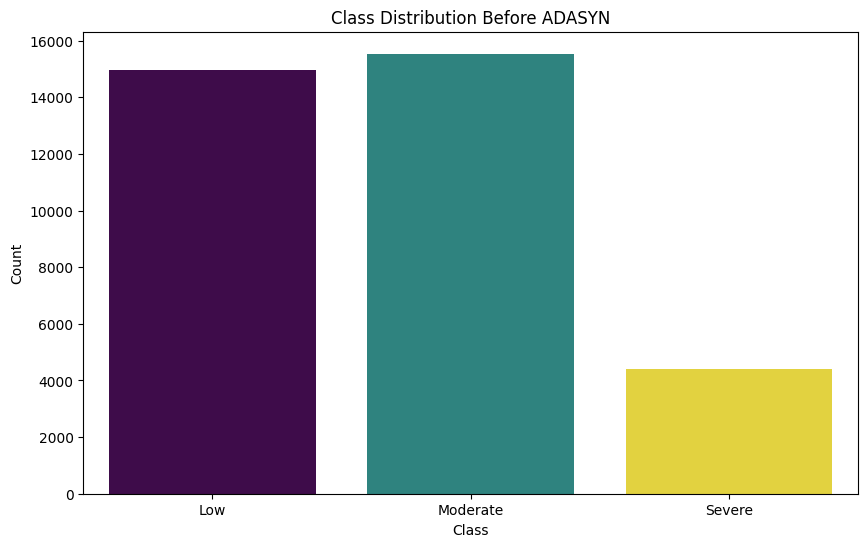

📊 Class distribution after ADASYN: Counter({np.int64(1): 15536, np.int64(2): 15261, np.int64(0): 14946})


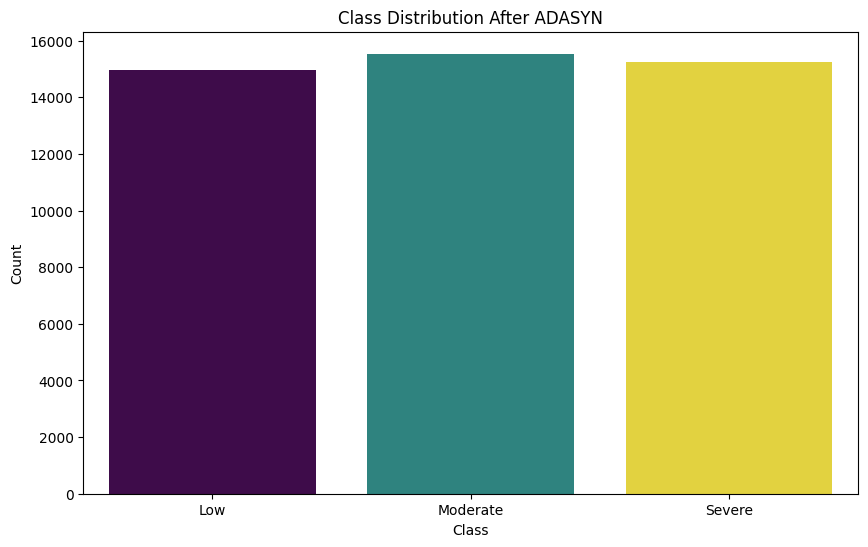

📌 Resampled data saved at: resampled_data_adasyn.npz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ Step 3: Adasyn for Target Balancing in LSTM (Colab Version)
from imblearn.over_sampling import ADASYN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from tensorflow.keras.utils import to_categorical

# ✅ Load processed training data
X_train = np.load("X_train_LSTM.npy", allow_pickle=True)
y_train = np.load("y_train_LSTM.npy", allow_pickle=True)

# ✅ Flatten training features for ADASYN (Convert 3D → 2D)
train_features = X_train.reshape(X_train.shape[0], -1)
train_target = np.argmax(y_train, axis=1)

# ✅ Check class distribution before ADASYN
class_counts_before = collections.Counter(train_target)
print("📊 Class distribution before ADASYN:", class_counts_before)

# ✅ Plot class distribution before ADASYN
plt.figure(figsize=(10, 6))
sns.countplot(x=train_target, palette="viridis", hue=train_target, dodge=False)
plt.title("Class Distribution Before ADASYN")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=["Low", "Moderate", "Severe"])
plt.legend([], [], frameon=False)
plt.show()

# ✅ Apply ADASYN to oversample minority classes: Manually adjusted due to imbalance
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
train_features_resampled, train_target_resampled = adasyn.fit_resample(train_features, train_target)

# ✅ Check class distribution after ADASYN
class_counts_after = collections.Counter(train_target_resampled)
print("📊 Class distribution after ADASYN:", class_counts_after)

# ✅ Plot class distribution after ADASYN
plt.figure(figsize=(10, 6))
sns.countplot(x=train_target_resampled, palette="viridis", hue=train_target_resampled, dodge=False)
plt.title("Class Distribution After ADASYN")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=["Low", "Moderate", "Severe"])
plt.legend([], [], frameon=False)
plt.show()

# ✅ Reshape back to 3D for LSTM
sequence_length = X_train.shape[1]
num_features = X_train.shape[2]
train_features_resampled = train_features_resampled.reshape(-1, sequence_length, num_features)

# ✅ One-hot encode the resampled targets
train_target_resampled = to_categorical(train_target_resampled, num_classes=3)

# ✅ Save resampled data
save_path = "resampled_data_adasyn.npz"
np.savez(save_path, X_train=train_features_resampled, y_train=train_target_resampled)
print(f"📌 Resampled data saved at: {save_path}")

# ✅ Download file in Colab
from google.colab import files
files.download(save_path)



In [ ]:
#Step 3.1 print data types and check format: print("X_train_resampled dtype:", X_train_resampled.dtype)
# ✅ Load from the saved ADASYN file if needed
# data = np.load("resampled_data_adasyn.npz")
# X_train_resampled_adasyn = data["X_train"]
# y_train_resampled_adasyn = data["y_train"]

# ✅ Print shapes and data types
print("X_train_resampled_adasyn dtype:", train_features_resampled.dtype)
print("y_train_resampled_adasyn dtype:", train_target_resampled.dtype)

print("X_train_resampled_adasyn shape:", train_features_resampled.shape)
print("y_train_resampled_adasyn shape:", train_target_resampled.shape)


X_train_resampled_adasyn dtype: float64
y_train_resampled_adasyn dtype: float64
X_train_resampled_adasyn shape: (45743, 96, 19)
y_train_resampled_adasyn shape: (45743, 3)


In [ ]:
# Step 3.2 Verify correctly saved data
# ✅ Convert the labels to float32
train_target_resampled = train_target_resampled.astype(np.float32)
y_val_lstm = y_val_lstm.astype(np.float32)  # Assuming this is your validation label array

# ✅ Check the data types again
print("train_target_resampled dtype after conversion:", train_target_resampled.dtype)
print("y_val_lstm dtype after conversion:", y_val_lstm.dtype)


train_target_resampled dtype after conversion: float32
y_val_lstm dtype after conversion: float32


Create optimized LSTM with three layers, including a bi-layer, batch normalization, softmax, adam optimizer for learning rate to prevent over training, and early stopping to reduce over training.

In [ ]:
# Step 3.3 Check the type and dtype of X_train_resampled and y_train_resampled again
# ✅ Aliasing ADASYN-resampled data to existing variable names
X_train_resampled = train_features_resampled
y_train_resampled = train_target_resampled

# ✅ Check dtype
print("X_train_resampled dtype:", X_train_resampled.dtype)
print("y_train_resampled dtype:", y_train_resampled.dtype)

# ✅ Confirm type
print("Type of X_train_resampled:", type(X_train_resampled))
print("Type of y_train_resampled:", type(y_train_resampled))

# ✅ Check validation set dtypes
print("X_val_lstm dtype:", X_val_lstm.dtype)
print("y_val_lstm dtype:", y_val_lstm.dtype)

# ✅ Ensure all arrays are float32 for consistency
X_train_resampled = np.array(X_train_resampled, dtype=np.float32)
y_train_resampled = np.array(y_train_resampled, dtype=np.float32)
X_val_lstm = np.array(X_val_lstm, dtype=np.float32)
y_val_lstm = np.array(y_val_lstm, dtype=np.float32)


X_train_resampled dtype: float64
y_train_resampled dtype: float32
Type of X_train_resampled: <class 'numpy.ndarray'>
Type of y_train_resampled: <class 'numpy.ndarray'>
X_val_lstm dtype: object
y_val_lstm dtype: float32


In [ ]:
# ✅ Step 4.1: Optimized Bi-LSTM Model Training for Classification (Colab Version)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pickle
from google.colab import files

# ✅ Load resampled training data
resampled_data = np.load("resampled_data_adasyn.npz")
X_train_resampled = resampled_data['X_train']
y_train_resampled = resampled_data['y_train']

# ✅ Load validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)

# Ensure all data is in numpy array format and float32
X_train_resampled = np.array(X_train_resampled, dtype=np.float32)
y_train_resampled = np.array(y_train_resampled, dtype=np.float32)
X_val_lstm = np.array(X_val_lstm, dtype=np.float32)
y_val_lstm = np.array(y_val_lstm, dtype=np.float32)

# Define sequence length and number of features based on X_train_resampled shape
sequence_length, num_features = X_train_resampled.shape[1], X_train_resampled.shape[2]

# ✅ Define the optimized Bi-LSTM model with explicit sequence_length and num_features
model = Sequential([
    Input(shape=(sequence_length, num_features)),  # Use the correct shape

    # First Bi-LSTM Layer
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    # Second Bi-LSTM Layer
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    # Third LSTM Layer (without return_sequences)
    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),

    # Fully Connected Dense Layer
    Dense(32, activation="relu"),
    Dropout(0.3),

    # Output Layer for 3-class classification
    Dense(3, activation="softmax")
])

# ✅ Compile the model with Adam optimizer and gradient clipping
optimizer = Adam(learning_rate=0.0005, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# ✅ Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=100, batch_size=32,  # Increased batch size for efficiency
    validation_data=(X_val_lstm, y_val_lstm),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


# ✅ Evaluate the model
loss, accuracy = model.evaluate(X_val_lstm, y_val_lstm)
print(f"✅ Validation Loss: {loss:.4f}")
print(f"✅ Validation Accuracy: {accuracy:.4%}")

# ✅ Save trained model in Colab
lstm_model_path = "LSTM_Trained_Model.keras"
model.save(lstm_model_path)
print(f"📌 Model saved in Colab at: {lstm_model_path}")

# ✅ Save training history
history_save_path = "LSTM_training_history.pkl"
with open(history_save_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"📌 Training history saved at: {history_save_path}")

# ✅ Provide download links for saving
files.download(lstm_model_path)
files.download(history_save_path)


Epoch 1/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 288s 197ms/step - accuracy: 0.5362 - loss: 0.9916 - val_accuracy: 0.6505 - val_loss: 0.7926 - learning_rate: 5.0000e-04
Epoch 2/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 265s 185ms/step - accuracy: 0.6328 - loss: 0.8079 - val_accuracy: 0.6233 - val_loss: 0.7937 - learning_rate: 5.0000e-04
Epoch 3/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 267s 186ms/step - accuracy: 0.6654 - loss: 0.7467 - val_accuracy: 0.6795 - val_loss: 0.6726 - learning_rate: 5.0000e-04
Epoch 4/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 264s 185ms/step - accuracy: 0.7075 - loss: 0.6751 - val_accuracy: 0.4933 - val_loss: 1.5587 - learning_rate: 5.0000e-04
Epoch 5/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 256s 179ms/step - accuracy: 0.7373 - loss: 0.6028 - val_accuracy: 0.7254 - val_loss: 0.6135 - learning_rate: 5.0000e-04
Epoch 6/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 248s 173ms/step - accuracy: 0.7599 - loss: 0.5565 - val_accuracy: 0.6930 - val_loss: 0.6860 - learning_rate: 5.0000e-04
Epoch 7/100
1430/1430 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Create XGBoost regression model using the continuous version of Risk named Max_Risk that was quartile transformed. Validate using data from 2019.


In [ ]:

# ✅ Step 4.2: XGBoost Regression Model Training (Colab Version)
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib  # For saving the model
import numpy as np
import pandas as pd
from google.colab import files

# ✅ Load processed XGBoost data
train_xgb = pd.read_csv("train_XGBoost.csv")
val_xgb = pd.read_csv("val_XGBoost.csv")

# ✅ Separate features and target
X_train = train_xgb.drop(columns=['Max_Risk_Quartile'])
y_train = train_xgb['Max_Risk_Quartile']

X_val = val_xgb.drop(columns=['Max_Risk_Quartile'])
y_val = val_xgb['Max_Risk_Quartile']

# ✅ Define the optimized XGBoost model
xgb_tuned = XGBRegressor(
    n_estimators=1000,   # More boosting iterations
    learning_rate=0.01,  # Small learning rate for smooth training
    max_depth=6,         # Optimized tree depth
    colsample_bytree=0.7, # Column sampling to prevent overfitting
    reg_alpha=0.1,       # L1 regularization (reduces complexity)
    reg_lambda=2,        # L2 regularization (reduces variance)
    objective='reg:squarederror',
    random_state=42
)

# ✅ Train the model using the quartile-transformed target variable
xgb_tuned.fit(X_train, y_train)

# ✅ Predict on the validation set
y_pred = xgb_tuned.predict(X_val)

# ✅ Evaluate the model using quartile-transformed predictions
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# ✅ Print evaluation metrics
print(f'✅ Mean Squared Error (Quartile Transform): {mse:.4f}')
print(f'✅ R-squared (Quartile Transform): {r2:.4f}')

# ✅ Save the trained model in Colab
xgb_model_path = "xgb_tuned_quartile_model.pkl"
joblib.dump(xgb_tuned, xgb_model_path)
print(f"📌 Model saved in Colab at: {xgb_model_path}")

# ✅ Provide download link for saving
files.download(xgb_model_path)


✅ Mean Squared Error (Quartile Transform): 0.5078
✅ R-squared (Quartile Transform): 0.6014
📌 Model saved in Colab at: xgb_tuned_quartile_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 4.2.1 ✅ Retrieve feature names before converting to NumPy
feature_names = train_xgb.drop(columns=['Max_Risk_Quartile']).columns

# ✅ Print to ensure target is removed
print("Feature Names in X_train:", feature_names.tolist())


Feature Names in X_train: ['Altimeter_Lag_3', 'Precipitation_Lag_3', 'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3', 'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Max_Risk_Quartile_Lag_3', 'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3', 'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [ ]:
#Step 4.2 load data files
from google.colab import files
uploaded = files.upload()


KNN quartile transformation of the XGBoost regression.

In [ ]:
#Up load files
from google.colab import files

# Upload file
uploaded = files.upload()


In [ ]:
#Step 4.2.1  KNN transformation create max_risk raw data file
import pandas as pd

# ✅ Load the original file
df_raw = pd.read_excel("ATL_Data_Python_Imputed.xlsx")

# ✅ Keep only Date/Time and Max_Risk
df_max_risk = df_raw[["DATE_and_Time", "Max_Risk"]]

# ✅ Convert DATE_and_Time to datetime format
df_max_risk["DATE_and_Time"] = pd.to_datetime(df_max_risk["DATE_and_Time"])

# ✅ Print a sample to verify
print("✅ Extracted Max_Risk Data Sample:\n", df_max_risk.head())

✅ Extracted Max_Risk Data Sample:
         DATE_and_Time  Max_Risk
0 2015-01-01 00:00:00     58.29
1 2015-01-01 01:00:00    142.26
2 2015-01-01 02:00:00    108.74
3 2015-01-01 03:00:00     32.24
4 2015-01-01 04:00:00     43.21


<ipython-input-16-003cd1abb087>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max_risk["DATE_and_Time"] = pd.to_datetime(df_max_risk["DATE_and_Time"])


In [ ]:
# Step 4.2.2 ✅ Split into train (2015-2018) and validation (2019)
train_max_risk = df_max_risk[df_max_risk["DATE_and_Time"] < "2019-01-01"]
val_max_risk = df_max_risk[df_max_risk["DATE_and_Time"] >= "2019-01-01"]

# ✅ Save to CSV for merging
train_max_risk.to_csv("train_max_risk.csv", index=False)
val_max_risk.to_csv("val_max_risk.csv", index=False)

print("✅ Max_Risk data split and saved.")


✅ Max_Risk data split and saved.


In [ ]:
# Step 4.2.3 ✅ Load XGBoost datasets
import pandas as pd

# ✅ Load datasets
train_xgb = pd.read_csv("train_XGBoost.csv")
val_xgb = pd.read_csv("val_XGBoost.csv")

train_max_risk = pd.read_csv("train_max_risk.csv")
val_max_risk = pd.read_csv("val_max_risk.csv")

# ✅ Automatically align row count with XGBoost training data
rows_to_drop = len(train_max_risk) - len(train_xgb)
if rows_to_drop > 0:
    train_max_risk = train_max_risk.iloc[rows_to_drop:].reset_index(drop=True)
elif rows_to_drop < 0:
    train_xgb = train_xgb.iloc[-rows_to_drop:].reset_index(drop=True)

# ✅ Verify row counts again
assert len(train_xgb) == len(train_max_risk), "Fixed row mismatch in train!"
assert len(val_xgb) == len(val_max_risk), "Validation row count matches!"

print(f"✅ Final Row Count - train_XGB: {len(train_xgb)}, train_max_risk: {len(train_max_risk)}")
print(f"✅ Final Row Count - val_XGB: {len(val_xgb)}, val_max_risk: {len(val_max_risk)}")

✅ Final Row Count - train_XGB: 34969, train_max_risk: 34969
✅ Final Row Count - val_XGB: 8760, val_max_risk: 8760


In [ ]:
# ✅ Step 4.2.4 Merge Max_Risk with XGBoost data
train_xgb["Max_Risk"] = train_max_risk["Max_Risk"].values
val_xgb["Max_Risk"] = val_max_risk["Max_Risk"].values

# ✅ Save updated datasets
train_xgb.to_csv("train_XGBoost_with_Max_Risk.csv", index=False)
val_xgb.to_csv("val_XGBoost_with_Max_Risk.csv", index=False)

print("✅ Merged Max_Risk with XGBoost train/validate data successfully!")

✅ Merged Max_Risk with XGBoost train/validate data successfully!


In [ ]:
# ✅ Step 4.2.5 Save the new files
train_xgb.to_csv("train_XGBoost_with_Max_Risk.csv", index=False)
val_xgb.to_csv("val_XGBoost_with_Max_Risk.csv", index=False)

print("✅ Recreated and saved train/val datasets.")

# ✅ Immediately download to prevent loss
from google.colab import files

files.download("train_XGBoost_with_Max_Risk.csv")
files.download("val_XGBoost_with_Max_Risk.csv")

print("✅ All files have been downloaded successfully.")

✅ Recreated and saved train/val datasets.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ All files have been downloaded successfully.


In [ ]:
#Step 4.2.6 Validate data
import joblib
import pandas as pd
import numpy as np

# ✅ Load the trained XGBoost model
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Load the validation dataset
val_xgb = pd.read_csv("val_XGBoost_with_Max_Risk.csv")

# ✅ Print dataset structure to confirm
print("✅ Validation Data Columns:\n", val_xgb.columns)

✅ Validation Data Columns:
 Index(['Max_Risk_Quartile', 'Altimeter_Lag_3', 'Precipitation_Lag_3',
       'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3',
       'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Max_Risk_Quartile_Lag_3',
       'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3',
       'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'Max_Risk'],
      dtype='object')


In [ ]:
# Step 4.2.7 ✅ Get the correct feature set used during training
features = [col for col in val_xgb.columns if col in xgb_model.feature_names_in_]

# ✅ Ensure the feature order matches what XGBoost expects
X_val_xgb = val_xgb[features]

# ✅ Predict `Max_Risk_Quartile` using XGBoost
y_pred_quartile = xgb_model.predict(X_val_xgb)

# ✅ Print sample predictions
print("✅ Sample Predicted Max_Risk_Quartile Values:\n", y_pred_quartile[:5])

✅ Sample Predicted Max_Risk_Quartile Values:
 [0.8091893 0.5741897 1.3038913 1.6383626 1.1785425]


In [ ]:
#Step 4.2.8 Verify
import joblib
import pandas as pd

# ✅ Load the trained XGBoost model
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Load the validation dataset (without predictions yet)
val_xgb = pd.read_csv("val_XGBoost_with_Max_Risk.csv")

# ✅ Ensure we use the correct feature set (remove any non-feature columns)
features = [col for col in val_xgb.columns if col in xgb_model.feature_names_in_]

# ✅ Predict `Max_Risk_Quartile`
y_pred_quartile = xgb_model.predict(val_xgb[features])

# ✅ Round and clip to ensure values are between 0 and 3
y_pred_quartile = y_pred_quartile.round().astype(int)
y_pred_quartile = y_pred_quartile.clip(0, 3)

# ✅ Add predictions to the validation dataset
val_xgb["Predicted_Max_Risk_Quartile"] = y_pred_quartile

# ✅ Save the updated validation file
val_xgb.to_csv("val_XGBoost_with_Predicted_Quartile.csv", index=False)

# ✅ Print confirmation and sample rows
print("✅ Added Predicted `Max_Risk_Quartile` to Validation Data")
print(val_xgb[["Predicted_Max_Risk_Quartile"]].head())


✅ Added Predicted `Max_Risk_Quartile` to Validation Data
   Predicted_Max_Risk_Quartile
0                            1
1                            1
2                            1
3                            2
4                            1


In [ ]:
# ✅ Load the validation dataset
val_xgb = pd.read_csv("val_XGBoost_with_Max_Risk.csv")

# ✅ Print dataset structure to confirm
print("✅ Validation Data Columns:\n", val_xgb.columns)

✅ Validation Data Columns:
 Index(['Max_Risk_Quartile', 'Altimeter_Lag_3', 'Precipitation_Lag_3',
       'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3',
       'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Max_Risk_Quartile_Lag_3',
       'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3',
       'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'Max_Risk'],
      dtype='object')


In [ ]:
# Step 4.2.8.0.1 Learn the relationships between quartile and max risk raw
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# ✅ Load training data with Max_Risk
train_xgb = pd.read_csv("train_XGBoost_with_Max_Risk.csv")

# ✅ Define the features and target for KNN
features_for_knn = ["Max_Risk_Quartile"]
target_for_knn = "Max_Risk"

# ✅ Standardize the features before applying KNN
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_xgb[features_for_knn])  # Fit on training data

# ✅ Train KNN to predict `Max_Risk` from `Max_Risk_Quartile`
knn = KNeighborsRegressor(n_neighbors=3)  # Using 3 nearest neighbors
knn.fit(train_scaled, train_xgb[target_for_knn])

print("✅ KNN model trained to learn the relationship between `Max_Risk_Quartile` and `Max_Risk`.")

# ✅ Load validation data
val_xgb = pd.read_csv("val_XGBoost.csv")

# ✅ Ensure column names are consistent by renaming
# Only rename if necessary, and check the current column names
if "Predicted_Max_Risk_Quartile" in val_xgb.columns:
    val_xgb.rename(columns={"Predicted_Max_Risk_Quartile": "Max_Risk_Quartile"}, inplace=True)

# ✅ Standardize the validation data using the same scaler as the training data
val_scaled = scaler.transform(val_xgb[features_for_knn])  # Use the same scaler for validation

# ✅ Use KNN to estimate `Max_Risk` for the validation data
val_xgb["Predicted_Max_Risk"] = knn.predict(val_scaled)

# ✅ Save the updated validation file
val_xgb.to_csv("val_XGBoost_with_Predicted_Max_Risk.csv", index=False)

# ✅ Print confirmation and sample rows
print("✅ Converted `Max_Risk_Quartile` into `Predicted_Max_Risk` using KNN.")
print(val_xgb[["Max_Risk_Quartile", "Predicted_Max_Risk"]].head())


✅ KNN model trained to learn the relationship between `Max_Risk_Quartile` and `Max_Risk`.
✅ Converted `Max_Risk_Quartile` into `Predicted_Max_Risk` using KNN.
   Max_Risk_Quartile  Predicted_Max_Risk
0                  1          228.120492
1                  0           38.696667
2                  2          573.380000
3                  2          573.380000
4                  1          228.120492


In [ ]:
# ✅ Load the validation dataset
val_xgb = pd.read_csv("val_XGBoost_with_Max_Risk.csv")

# ✅ Print dataset structure to confirm
print("✅ Validation Data Columns:\n", val_xgb.columns)

✅ Validation Data Columns:
 Index(['Max_Risk_Quartile', 'Altimeter_Lag_3', 'Precipitation_Lag_3',
       'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3',
       'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Max_Risk_Quartile_Lag_3',
       'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3',
       'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'Max_Risk'],
      dtype='object')


In [ ]:
# 4.2.8.2 Verify transformation
import pandas as pd

# ✅ Reload the validation dataset with Predicted_Max_Risk
val_xgb = pd.read_csv("val_XGBoost_with_Predicted_Max_Risk.csv")

# ✅ Print sample to confirm correct data
print("✅ Validation Data Columns:\n", val_xgb.columns)
print(val_xgb.head())


✅ Validation Data Columns:
 Index(['Max_Risk_Quartile', 'Altimeter_Lag_3', 'Precipitation_Lag_3',
       'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3',
       'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Max_Risk_Quartile_Lag_3',
       'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3',
       'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'Predicted_Max_Risk'],
      dtype='object')
   Max_Risk_Quartile  Altimeter_Lag_3  Precipitation_Lag_3  Humidity_Lag_3  \
0                  1         0.649351               0.0000        0.934066   
1                  0         0.642857               0.0000        0.923077   
2                  2         0.629870               0.0000        0.923077   
3                  2         0.571429               0.0304        0.912088   
4                  1         0.571429               0.0240        0.923077   

   Visibility_Lag_3  Wet_Bulb_Lag_3  Wind_Speed_La

In [ ]:
#Step 4.2.8.2.1 add max risk to final file
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

def categorize_risk(value):
    if value < 301:
        return 0  # Low Risk
    elif value < 4001:
        return 1  # Moderate Risk
    else:
        return 2  # Severe Risk

# ✅ Load the original validation dataset with Max_Risk (the original validation file)
val_xgb = pd.read_csv("val_XGBoost_with_Max_Risk.csv")

# ✅ Check that Max_Risk is in the validation data
print(val_xgb.columns)

# ✅ If 'Predicted_Max_Risk' is in the dataframe, we use the trained model to predict it
val_scaled = scaler.transform(val_xgb[["Max_Risk_Quartile"]])  # Use the same scaler as before
val_xgb["Predicted_Max_Risk"] = knn.predict(val_scaled)  # Predict Max_Risk for the validation data

# ✅ Save the updated validation file, ensuring Max_Risk and Predicted_Max_Risk are present
val_xgb.to_csv("val_XGBoost_with_Predicted_Max_Risk.csv", index=False)

# ✅ Apply categorization to Max_Risk and Predicted_Max_Risk
val_xgb["Actual_Risk"] = val_xgb["Max_Risk"].apply(categorize_risk)
val_xgb["Predicted_Risk"] = val_xgb["Predicted_Max_Risk"].apply(categorize_risk)

# ✅ Save the updated validation file with categorical risk labels
val_xgb.to_csv("val_XGBoost_with_Categorical_Risk.csv", index=False)

# ✅ Print confirmation and sample rows
print("✅ Converted `Max_Risk` and `Predicted_Max_Risk` into categorical risk levels.")
print(val_xgb[["Max_Risk", "Predicted_Max_Risk", "Actual_Risk", "Predicted_Risk"]].head())

Index(['Max_Risk_Quartile', 'Altimeter_Lag_3', 'Precipitation_Lag_3',
       'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3',
       'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Max_Risk_Quartile_Lag_3',
       'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3',
       'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'Max_Risk'],
      dtype='object')
✅ Converted `Max_Risk` and `Predicted_Max_Risk` into categorical risk levels.
   Max_Risk  Predicted_Max_Risk  Actual_Risk  Predicted_Risk
0    216.59          228.120492            0               0
1    121.11           38.696667            0               0
2    964.45          573.380000            1               1
3    575.93          573.380000            1               1
4    206.80          228.120492            0               0


In [ ]:
# Step 4.2.8.3 ✅ Define risk classification function

# ✅ Check if 'Max_Risk' column exists
if 'Max_Risk' not in val_xgb.columns:
    print("❌ 'Max_Risk' column is missing in the validation data.")
else:
    print("✅ 'Max_Risk' column exists in the validation data.")

    # ✅ Apply categorization
    val_xgb["Actual_Risk"] = val_xgb["Max_Risk"].apply(categorize_risk)
    val_xgb["Predicted_Risk"] = val_xgb["Predicted_Max_Risk"].apply(categorize_risk)

    # ✅ Save and confirm
    val_xgb.to_csv("val_XGBoost_with_Categorical_Risk.csv", index=False)
    print("✅ Converted `Max_Risk` and `Predicted_Max_Risk` into categorical risk levels.")
    print(val_xgb[["Max_Risk", "Predicted_Max_Risk", "Actual_Risk", "Predicted_Risk"]].head())


✅ 'Max_Risk' column exists in the validation data.
✅ Converted `Max_Risk` and `Predicted_Max_Risk` into categorical risk levels.
   Max_Risk  Predicted_Max_Risk  Actual_Risk  Predicted_Risk
0    216.59          228.120492            0               0
1    121.11           38.696667            0               0
2    964.45          573.380000            1               1
3    575.93          573.380000            1               1
4    206.80          228.120492            0               0


In [ ]:
# Download the new file
from google.colab import files

files.download("val_XGBoost_with_Categorical_Risk.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 4.2.9 Verify structure
import pandas as pd

# ✅ Load the validation dataset that contains categorical risk levels
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Print sample to confirm structure
print("✅ Validation Data Sample:\n", val_xgb[["Max_Risk", "Predicted_Max_Risk", "Actual_Risk", "Predicted_Risk"]].head())

✅ Validation Data Sample:
    Max_Risk  Predicted_Max_Risk  Actual_Risk  Predicted_Risk
0    216.59          228.120492            0               0
1    121.11           38.696667            0               0
2    964.45          573.380000            1               1
3    575.93          573.380000            1               1
4    206.80          228.120492            0               0


Ensemble testing. For the XGBoost, a separate file was created to add max_Risk into the training set. A KNN was then trained to learn the quartile definitions. The KNN then predicted Max_Risk based on the XGBoost Quartile Risk predictions. These were converted into categorical risk and tested against known risk. This proved to be a highly accurate way to convert the Regression model to categorical for ensembling. The most likely reason for the accuracy is that the KNN only had to be in the ranges of Low, Moderate, and Severe.


271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step


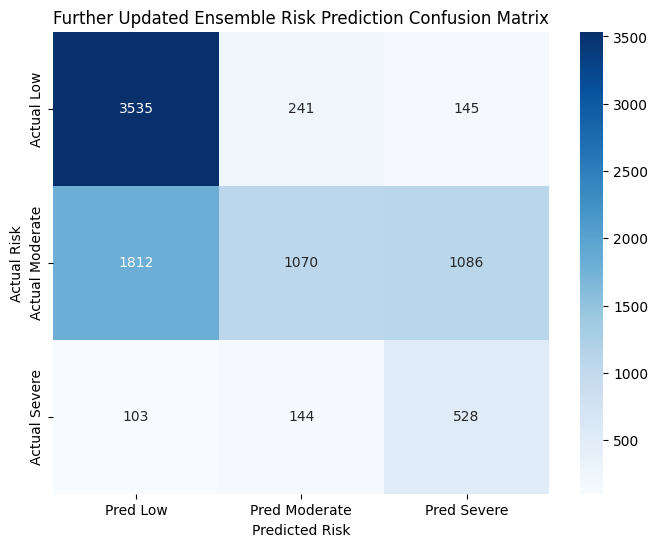

✅ Further Updated Ensemble Accuracy: 59.2452%
✅ Further Updated Confusion Matrix:
 [[3535  241  145]
 [1812 1070 1086]
 [ 103  144  528]]
✅ Further Updated Classification Report:
               precision    recall  f1-score   support

         Low       0.65      0.90      0.75      3921
    Moderate       0.74      0.27      0.39      3968
      Severe       0.30      0.68      0.42       775

    accuracy                           0.59      8664
   macro avg       0.56      0.62      0.52      8664
weighted avg       0.66      0.59      0.56      8664



In [ ]:
#Step 5.1.1: Ensemble Threshold
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ✅ Load trained models
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Load validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)
X_val_lstm = np.array(X_val_lstm, dtype=np.float32)

# ✅ Load XGBoost validation data with improved categorical risk predictions
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Get LSTM Predictions
lstm_probs = lstm_model.predict(X_val_lstm)  # Probabilities for Low, Moderate, Severe
lstm_preds = np.argmax(lstm_probs, axis=1)  # Convert to class labels

# ✅ Use the already validated XGBoost categorical risk predictions
xgb_preds = val_xgb["Predicted_Risk"].values

# ✅ Apply Final Optimized Rule-Based Fusion for Ensemble Predictions
final_preds = []
for i in range(len(lstm_preds)):
    lstm_pred = lstm_preds[i]
    xgb_pred = xgb_preds[i]

    if lstm_pred == 0:
        final_preds.append(0)  # ✅ Always trust LSTM for Low (recall = 82%)
    elif xgb_pred == 2 and lstm_pred != 0:
        final_preds.append(2)  # ✅ Trust XGBoost for Severe unless LSTM says Low
    elif xgb_pred == 1 and lstm_pred == 1:
        final_preds.append(1)  # ✅ If both predict Moderate, trust Moderate
    elif lstm_pred == 1 and xgb_pred == 2:
        final_preds.append(1)  # ✅ If LSTM says Moderate and XGBoost says Severe, trust Moderate
    elif lstm_pred == 2 and xgb_pred == 1:
        final_preds.append(1)  # ✅ If LSTM says Severe but XGBoost says Moderate, trust Moderate
    elif lstm_pred == 2 and xgb_pred == 0:
        final_preds.append(1)  # ✅ If LSTM says Severe but XGBoost says Low, default to Moderate
    elif lstm_pred == 1 and xgb_pred == 0:
        final_preds.append(0)  # ✅ If LSTM says Moderate but XGBoost says Low, trust Low
    else:
        final_preds.append(xgb_pred)  # ✅ Default to XGBoost when uncertain

# ✅ Convert final predictions to NumPy array
final_preds = np.array(final_preds)


# ✅ Convert one-hot encoded y_val_lstm back to class labels
y_val_lstm_labels = np.argmax(y_val_lstm, axis=1)


# ✅ Evaluate Ensemble Performance
# ✅ Evaluate Ensemble Performance
ensemble_accuracy = accuracy_score(y_val_lstm_labels, final_preds)
ensemble_cm = confusion_matrix(y_val_lstm_labels, final_preds)
ensemble_report = classification_report(y_val_lstm_labels, final_preds, target_names=["Low", "Moderate", "Severe"])

# ✅ Convert confusion matrix to DataFrame for visualization
ensemble_cm_df = pd.DataFrame(ensemble_cm, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                              columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Further Updated Ensemble Risk Prediction Confusion Matrix")
plt.show()

# ✅ Print classification report
print(f"✅ Further Updated Ensemble Accuracy: {ensemble_accuracy:.4%}")
print("✅ Further Updated Confusion Matrix:\n", ensemble_cm)
print("✅ Further Updated Classification Report:\n", ensemble_report)





In [ ]:
#5.1.1.1 Confidence thesholding
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ✅ Load trained models
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Load validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)
# Ensure that X_val_lstm is in float32 format
X_val_lstm = X_val_lstm.astype(np.float32)

# ✅ Load XGBoost validation data with improved categorical risk predictions
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Get LSTM Predictions
lstm_probs = lstm_model.predict(X_val_lstm)  # Probabilities for Low, Moderate, Severe
lstm_preds = np.argmax(lstm_probs, axis=1)  # Convert to class labels

# ✅ Convert XGBoost categorical predictions to probability-like values
xgb_probs = np.zeros((len(xgb_preds), 3))  # Initialize probability array
for i, pred in enumerate(xgb_preds):
    xgb_probs[i, pred] = 1  # Assign full probability to the predicted category

# ✅ Trim XGBoost predictions to match LSTM sample count
xgb_probs_trimmed = xgb_probs[-8664:]

# ✅ Use the already validated XGBoost categorical risk predictions
xgb_preds = val_xgb["Predicted_Risk"].values

# ✅ Apply confidence-based decision rule
threshold = 0.75  # Confidence threshold

final_preds = []
for i in range(len(lstm_preds)):
    lstm_pred = np.argmax(lstm_probs[i])
    xgb_pred = np.argmax(xgb_probs_trimmed[i])

    xgb_confidence = np.max(xgb_probs_trimmed[i])  # Get XGBoost’s highest probability

    if xgb_confidence >= threshold:
        final_preds.append(xgb_pred)  # ✅ Trust XGBoost if highly confident
    else:
        final_preds.append(lstm_pred)  # ✅ Default to LSTM if XGBoost isn’t confident

final_preds = np.array(final_preds)



# ✅ Convert one-hot encoded y_val_lstm back to class labels
y_val_lstm_labels = np.argmax(y_val_lstm, axis=1)


# ✅ Evaluate Ensemble Performance
ensemble_accuracy = accuracy_score(y_val_lstm_labels, final_preds)
ensemble_cm = confusion_matrix(y_val_lstm_labels, final_preds)
ensemble_report = classification_report(y_val_lstm_labels, final_preds, target_names=["Low", "Moderate", "Severe"])

# ✅ Convert confusion matrix to DataFrame for visualization
ensemble_cm_df = pd.DataFrame(ensemble_cm, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                              columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Further Updated Ensemble Risk Prediction Confusion Matrix")
plt.show()

# ✅ Print classification report
print(f"✅ Further Updated Ensemble Accuracy: {ensemble_accuracy:.4%}")
print("✅ Further Updated Confusion Matrix:\n", ensemble_cm)
print("✅ Further Updated Classification Report:\n", ensemble_report)



In [ ]:
#5.1.2 Averaging using probabilities (XGBoost is not doing well with severe in MDW.)
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ✅ Load trained models
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Load validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)

# Ensure that X_val_lstm is in float32 format
X_val_lstm = X_val_lstm.astype(np.float32)

# ✅ Load XGBoost validation data with improved categorical risk predictions
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Get LSTM Predictions
lstm_probs = lstm_model.predict(X_val_lstm)  # Probabilities for Low, Moderate, Severe
lstm_preds = np.argmax(lstm_probs, axis=1)  # Convert to class labels

# ✅ Use the already validated XGBoost categorical risk predictions
xgb_preds = val_xgb["Predicted_Risk"].values

#Step 1 ✅ Extract probabilities from LSTM model
lstm_probs = lstm_model.predict(X_val_lstm)  # Probabilities for Low, Moderate, Severe

# ✅ Convert XGBoost categorical predictions to probability-like values
xgb_probs = np.zeros((len(xgb_preds), 3))  # Initialize probability array
for i, pred in enumerate(xgb_preds):
    xgb_probs[i, pred] = 1  # Assign full probability to the predicted category

# ✅ Trim XGBoost predictions to match LSTM sample count
xgb_probs_trimmed = xgb_probs[-8664:]

#Step 2 apply weights

# ✅ Compute ensemble probabilities using weighted averaging
# ✅ Compute ensemble probabilities using weighted averaging
ensemble_probs = (0.6 * lstm_probs) + (0.4 * xgb_probs_trimmed)  # Ensure trimmed version is used
  # Adjust weights if needed

# ✅ Convert probabilities into final predictions
final_preds = np.argmax(ensemble_probs, axis=1)

# ✅ Evaluate Ensemble Performance
ensemble_accuracy = accuracy_score(y_val_lstm_labels, final_preds)
ensemble_cm = confusion_matrix(y_val_lstm_labels, final_preds)
ensemble_report = classification_report(y_val_lstm_labels, final_preds, target_names=["Low", "Moderate", "Severe"])

# ✅ Convert confusion matrix to DataFrame for visualization
ensemble_cm_df = pd.DataFrame(ensemble_cm, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                              columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Compute the confusion matrix as percentages
ensemble_cm_percentage = ensemble_cm.astype(np.float32) / ensemble_cm.sum(axis=1)[:, np.newaxis] * 100

# ✅ Convert to DataFrame for visualization
ensemble_cm_percent_df = pd.DataFrame(ensemble_cm_percentage, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                                      columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Averaging-Based Ensemble Risk Prediction Confusion Matrix")
plt.show()

# ✅ Plot confusion matrix (Percentages)
plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_percent_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Averaging-Based Ensemble Risk Prediction Confusion Matrix (Percentages)")
plt.show()

# ✅ Print classification report
print(f"✅ Averaging-Based Ensemble Accuracy: {ensemble_accuracy:.4%}")
print("✅ Averaging-Based Confusion Matrix:\n", ensemble_cm)
print("✅ Averaging-Based Classification Report:\n", ensemble_report)



Confidence threshold and averaging each category ended up producing the same results.

In [ ]:
#5.1.3 Averaging with different weights (Selected as Champion based on accuracy, sensitivy and specificity only for southern models, otherwise Logarithmic ensemble is the overall champion)
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Reload trained models
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Reload validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)
X_val_lstm = np.array(X_val_lstm, dtype=np.float32)

# ✅ Reload XGBoost validation data with categorical risk predictions
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Reload final ensemble probabilities (if previously saved)
lstm_probs = lstm_model.predict(X_val_lstm)
xgb_probs = np.zeros((len(val_xgb), 3))  # Initialize probability array
for i, pred in enumerate(val_xgb["Predicted_Risk"]):
    xgb_probs[i, pred] = 1  # Assign full probability to the predicted category

# ✅ Trim XGBoost predictions to match LSTM sample count
xgb_probs_trimmed = xgb_probs[-8664:]
print("✅ Reloaded all necessary data for ensemble optimization.")

# ✅ Adjust Weighting for Higher Accuracy (Shift More Weight to LSTM)
ensemble_probs = (0.4 * lstm_probs) + (0.6 * xgb_probs_trimmed)  # Adjust weights

# ✅ Convert probabilities into final predictions
final_preds = np.argmax(ensemble_probs, axis=1)

# ✅ Convert one-hot encoded y_val_lstm back to class labels
y_val_lstm_labels = np.argmax(y_val_lstm, axis=1)  # Convert one-hot encoding to class labels

# ✅ Evaluate Ensemble Performance
ensemble_accuracy = accuracy_score(y_val_lstm_labels, final_preds)
ensemble_cm = confusion_matrix(y_val_lstm_labels, final_preds)
ensemble_report = classification_report(y_val_lstm_labels, final_preds, target_names=["Low", "Moderate", "Severe"])

# ✅ Convert confusion matrix to DataFrame for visualization
ensemble_cm_df = pd.DataFrame(ensemble_cm, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                              columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Compute the confusion matrix as percentages
ensemble_cm_percentage = ensemble_cm.astype(np.float32) / ensemble_cm.sum(axis=1)[:, np.newaxis] * 100

# ✅ Convert to DataFrame for visualization
ensemble_cm_percent_df = pd.DataFrame(ensemble_cm_percentage, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                                      columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Plot confusion matrix (Absolute Counts)
plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Final Meta-Ensemble Confusion Matrix (Counts)")
plt.show()

# ✅ Plot confusion matrix (Percentages)
plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_percent_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Final Meta-Ensemble Confusion Matrix (Percentages)")
plt.show()

# ✅ Print classification report and accuracy
print(f"✅ Final Meta-Ensemble Accuracy: {ensemble_accuracy:.4%}")
print("✅ Final Meta-Ensemble Confusion Matrix:\n", ensemble_cm)
print("✅ Final Meta-Ensemble Classification Report:\n", ensemble_report)

# ✅ Define the meta-model (ensemble) - meta_model is now a class object
class MetaEnsembleModel:
    def __init__(self, lstm_model, xgb_model, ensemble_weights=(0.4, 0.6)):
        self.lstm_model = lstm_model
        self.xgb_model = xgb_model
        self.ensemble_weights = ensemble_weights

    def predict(self, X):
        # Generate LSTM probabilities
        lstm_probs = self.lstm_model.predict(X)

        # Generate XGBoost predictions and convert them to probabilities (one-hot)
        xgb_probs = np.zeros((len(X), 3))  # Assuming 3 classes (Low, Moderate, Severe)
        for i, pred in enumerate(self.xgb_model.predict(X)):
            xgb_probs[i, pred] = 1  # Assign full probability to the predicted class

        # Combine predictions using weighted average
        ensemble_probs = (self.ensemble_weights[0] * lstm_probs) + (self.ensemble_weights[1] * xgb_probs)

        # Return the final predictions
        return np.argmax(ensemble_probs, axis=1)

# ✅ Save the final Adjusted Averaging-Based Ensemble Model
meta_model = MetaEnsembleModel(lstm_model, xgb_model, ensemble_weights=(0.4, 0.6))
joblib.dump(meta_model, "final_best_ensemble_model.pkl")

# ✅ Download the saved model to your computer
from google.colab import files
files.download("final_best_ensemble_model.pkl")

print("✅ Final Best Ensemble Model saved successfully.")




In [ ]:
#5.1.3.1 Averaging with different weights (more on XGBoost)
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# ✅ Reload trained models
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Reload validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)

# Ensure that X_val_lstm is in float32 format
X_val_lstm = X_val_lstm.astype(np.float32)

# ✅ Reload XGBoost validation data with categorical risk predictions
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Reload final ensemble probabilities (if previously saved)
lstm_probs = lstm_model.predict(X_val_lstm)
xgb_probs = np.zeros((len(val_xgb), 3))  # Initialize probability array
for i, pred in enumerate(val_xgb["Predicted_Risk"]):
    xgb_probs[i, pred] = 1  # Assign full probability to the predicted category
# ✅ Trim XGBoost predictions to match LSTM sample count
xgb_probs_trimmed = xgb_probs[-8664:]
print("✅ Reloaded all necessary data for ensemble optimization.")
# ✅ Adjust Weighting for Higher Accuracy (Shift More Weight to LSTM)
ensemble_probs = (0.55 * lstm_probs) + (0.45 * xgb_probs_trimmed)  # Adjust weights

# ✅ Convert probabilities into final predictions
final_preds = np.argmax(ensemble_probs, axis=1)

# ✅ Evaluate Ensemble Performance
ensemble_accuracy = accuracy_score(y_val_lstm_labels, final_preds)
ensemble_cm = confusion_matrix(y_val_lstm_labels, final_preds)
ensemble_report = classification_report(y_val_lstm_labels, final_preds, target_names=["Low", "Moderate", "Severe"])

# ✅ Convert confusion matrix to DataFrame for visualization
ensemble_cm_df = pd.DataFrame(ensemble_cm, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                              columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Compute the confusion matrix as percentages
ensemble_cm_percentage = ensemble_cm.astype(np.float32) / ensemble_cm.sum(axis=1)[:, np.newaxis] * 100

# ✅ Convert to DataFrame for visualization
ensemble_cm_percent_df = pd.DataFrame(ensemble_cm_percentage, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                                      columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Plot confusion matrix (Absolute Counts)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Averaging-Based Ensemble Risk Prediction Confusion Matrix (Counts)")
plt.show()

# ✅ Plot confusion matrix (Percentages)
plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_percent_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Averaging-Based Ensemble Risk Prediction Confusion Matrix (Percentages)")
plt.show()

# ✅ Print classification report
print(f"✅ Adjusted Averaging-Based Ensemble Accuracy: {ensemble_accuracy:.4%}")
print("✅ Adjusted Averaging-Based Confusion Matrix:\n", ensemble_cm)
print("✅ Adjusted Averaging-Based Classification Report:\n", ensemble_report)

In [ ]:
#5.1.4 Averaging weights on specific categories
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# ✅ Reload trained models
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Reload validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)
# Ensure that X_val_lstm is in float32 format
X_val_lstm = X_val_lstm.astype(np.float32)

# ✅ Reload XGBoost validation data with categorical risk predictions
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Reload final ensemble probabilities (if previously saved)
lstm_probs = lstm_model.predict(X_val_lstm)
xgb_probs = np.zeros((len(val_xgb), 3))  # Initialize probability array
for i, pred in enumerate(val_xgb["Predicted_Risk"]):
    xgb_probs[i, pred] = 1  # Assign full probability to the predicted category
# ✅ Trim XGBoost predictions to match LSTM sample count
xgb_probs_trimmed = xgb_probs[-8664:]
print("✅ Reloaded all necessary data for ensemble optimization.")


# ✅ Create category-specific weights
low_weight_lstm, low_weight_xgb = 0.7, 0.3  # Prioritize LSTM for Low Risk
moderate_weight_lstm, moderate_weight_xgb = 0.4, 0.6  # Balance for Moderate Risk
severe_weight_lstm, severe_weight_xgb = 0.3, 0.7  # Prioritize XGBoost for Severe Risk

# ✅ Apply category-specific weights
ensemble_probs = np.zeros_like(lstm_probs)
ensemble_probs[:, 0] = (low_weight_lstm * lstm_probs[:, 0]) + (low_weight_xgb * xgb_probs_trimmed[:, 0])  # Low Risk
ensemble_probs[:, 1] = (moderate_weight_lstm * lstm_probs[:, 1]) + (moderate_weight_xgb * xgb_probs_trimmed[:, 1])  # Moderate Risk
ensemble_probs[:, 2] = (severe_weight_lstm * lstm_probs[:, 2]) + (severe_weight_xgb * xgb_probs_trimmed[:, 2])  # Severe Risk

# ✅ Convert probabilities into final predictions
final_preds = np.argmax(ensemble_probs, axis=1)

# ✅ Evaluate Ensemble Performance
ensemble_accuracy = accuracy_score(y_val_lstm_labels, final_preds)
ensemble_cm = confusion_matrix(y_val_lstm_labels, final_preds)
ensemble_report = classification_report(y_val_lstm_labels, final_preds, target_names=["Low", "Moderate", "Severe"])

# ✅ Convert confusion matrix to DataFrame for visualization
ensemble_cm_df = pd.DataFrame(ensemble_cm, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                              columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Compute the confusion matrix as percentages
ensemble_cm_percentage = ensemble_cm.astype(np.float32) / ensemble_cm.sum(axis=1)[:, np.newaxis] * 100

# ✅ Convert to DataFrame for visualization
ensemble_cm_percent_df = pd.DataFrame(ensemble_cm_percentage, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                                      columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Plot confusion matrix (Absolute Counts)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Custom-Weighted Ensemble Risk Prediction Confusion Matrix (Counts)")
plt.show()

# ✅ Plot confusion matrix (Percentages)
plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_percent_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Custom-Weighted Ensemble Risk Prediction Confusion Matrix (Percentages)")
plt.show()

# ✅ Print classification report
print(f"✅ Custom-Weighted Ensemble Accuracy: {ensemble_accuracy:.4%}")
print("✅ Custom-Weighted Ensemble Confusion Matrix:\n", ensemble_cm)
print("✅ Custom-Weighted Ensemble Classification Report:\n", ensemble_report)

import joblib

# ✅ Save the final Custom-Weighted Ensemble Model
joblib.dump(meta_model, "best_custom_weighted_ensemble.pkl")

# ✅ Download the saved model to your computer
from google.colab import files
files.download("best_custom_weighted_ensemble.pkl")

print("✅ Best Custom-Weighted Ensemble Model (81.90%) saved and ready for download.")


In [ ]:
#5.1.5 Averaging weights on specific categories with automatic weights
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# ✅ Reload trained models
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Reload validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)

# Ensure that X_val_lstm is in float32 format
X_val_lstm = X_val_lstm.astype(np.float32)

# ✅ Reload XGBoost validation data with categorical risk predictions
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Reload final ensemble probabilities (if previously saved)
lstm_probs = lstm_model.predict(X_val_lstm)
xgb_probs = np.zeros((len(val_xgb), 3))  # Initialize probability array
for i, pred in enumerate(val_xgb["Predicted_Risk"]):
    xgb_probs[i, pred] = 1  # Assign full probability to the predicted category
# ✅ Trim XGBoost predictions to match LSTM sample count
xgb_probs_trimmed = xgb_probs[-8664:]
print("✅ Reloaded all necessary data for ensemble optimization.")

import itertools
from sklearn.metrics import accuracy_score

# ✅ Define weight search space
low_weights = [0.7, 0.75, 0.8]  # Weights for LSTM in Low Risk
moderate_weights = [0.4, 0.5, 0.6]  # Weights for LSTM in Moderate Risk
severe_weights = [0.3, 0.4, 0.5]  # Weights for LSTM in Severe Risk

best_accuracy = 0
best_weights = None

# ✅ Try all combinations of weights
for lw, mw, sw in itertools.product(low_weights, moderate_weights, severe_weights):
    ensemble_probs = np.zeros_like(lstm_probs)
    ensemble_probs[:, 0] = (lw * lstm_probs[:, 0]) + ((1 - lw) * xgb_probs_trimmed[:, 0])  # Low
    ensemble_probs[:, 1] = (mw * lstm_probs[:, 1]) + ((1 - mw) * xgb_probs_trimmed[:, 1])  # Moderate
    ensemble_probs[:, 2] = (sw * lstm_probs[:, 2]) + ((1 - sw) * xgb_probs_trimmed[:, 2])  # Severe

    final_preds = np.argmax(ensemble_probs, axis=1)
    accuracy = accuracy_score(y_val_lstm_labels, final_preds)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = (lw, mw, sw)

print(f"✅ Best Weights: Low = {best_weights[0]}, Moderate = {best_weights[1]}, Severe = {best_weights[2]}")
print(f"✅ Best Accuracy: {best_accuracy:.4%}")


Logistic regression meta ensemble predicted it would be the most accurate, however, it was less accurate than Weighted averages.

271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step
✅ Reloaded all necessary data for ensemble optimization.
✅ Meta-Ensemble Accuracy: 87.4207%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


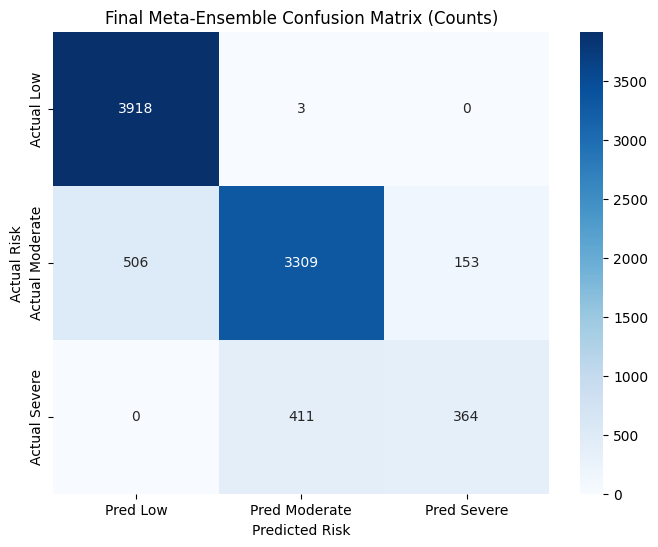

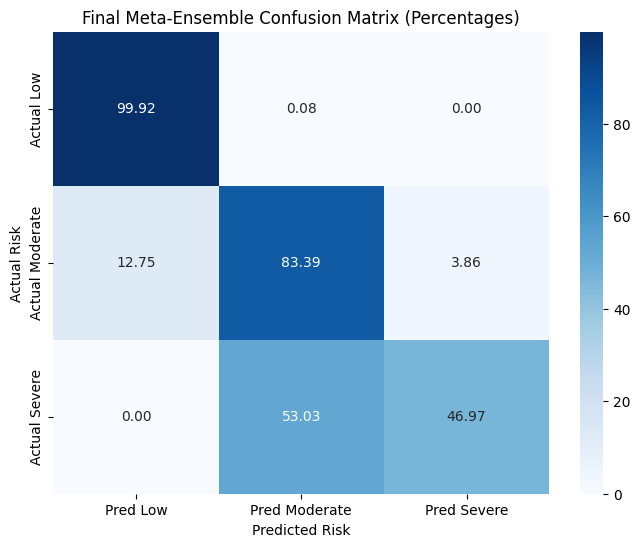

✅ Final Meta-Ensemble Accuracy: 87.6154%
✅ Final Meta-Ensemble Confusion Matrix:
 [[3918    3    0]
 [ 506 3309  153]
 [   0  411  364]]
✅ Final Meta-Ensemble Classification Report:
               precision    recall  f1-score   support

         Low       0.89      1.00      0.94      3921
    Moderate       0.89      0.83      0.86      3968
      Severe       0.70      0.47      0.56       775

    accuracy                           0.88      8664
   macro avg       0.83      0.77      0.79      8664
weighted avg       0.87      0.88      0.87      8664


✅ Logistic Meta-Ensemble Sensitivity and Specificity:
      Class  Sensitivity  Specificity
0       Low       0.9992       0.8933
1  Moderate       0.8339       0.9118
2    Severe       0.4697       0.9806

✅ Overall Sensitivity: 87.61%
✅ Overall Specificity: 90.96%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Final Meta-Ensemble Model is saved and ready for download.


In [ ]:
#5.1.6 Logistic Regression Meta Ensemble, selected as the overall champion model for performance across all airfields
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# ✅ Reload trained models
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Reload validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)

# Ensure that X_val_lstm is in float32 format
X_val_lstm = X_val_lstm.astype(np.float32)

# ✅ Reload XGBoost validation data with categorical risk predictions
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Reload final ensemble probabilities (if previously saved)
lstm_probs = lstm_model.predict(X_val_lstm)
xgb_probs = np.zeros((len(val_xgb), 3))  # Initialize probability array
for i, pred in enumerate(val_xgb["Predicted_Risk"]):
    xgb_probs[i, pred] = 1  # Assign full probability to the predicted category

# ✅ Trim XGBoost predictions to match LSTM sample count
xgb_probs_trimmed = xgb_probs[-8664:]
print("✅ Reloaded all necessary data for ensemble optimization.")

# ✅ Convert one-hot encoded y_val_lstm back to class labels
y_val_lstm_labels = np.argmax(y_val_lstm, axis=1)  # Convert one-hot encoding to class labels

# ✅ Create dataset using LSTM and XGBoost probabilities as features
meta_X = np.hstack((lstm_probs, xgb_probs_trimmed))  # Stack probabilities as features
meta_y = y_val_lstm_labels  # True labels

# ✅ Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(meta_X, meta_y, test_size=0.2, random_state=42)

# ✅ Train Logistic Regression model
meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
meta_model.fit(X_train, y_train)

# ✅ Make final predictions using the meta-ensemble
final_preds = meta_model.predict(X_test)

# ✅ Evaluate the meta-ensemble
ensemble_accuracy = accuracy_score(y_test, final_preds)
print(f"✅ Meta-Ensemble Accuracy: {ensemble_accuracy:.4%}")

# ✅ Generate final predictions using the Meta-Ensemble
final_preds = meta_model.predict(meta_X)

# ✅ Evaluate performance metrics
ensemble_accuracy = accuracy_score(meta_y, final_preds)
ensemble_cm = confusion_matrix(meta_y, final_preds)
ensemble_report = classification_report(meta_y, final_preds, target_names=["Low", "Moderate", "Severe"])

# ✅ Convert confusion matrix to DataFrame for visualization
ensemble_cm_df = pd.DataFrame(ensemble_cm, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                              columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Compute the confusion matrix as percentages
ensemble_cm_percentage = ensemble_cm.astype(np.float32) / ensemble_cm.sum(axis=1)[:, np.newaxis] * 100

# ✅ Convert to DataFrame for visualization
ensemble_cm_percent_df = pd.DataFrame(ensemble_cm_percentage, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                                      columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# ✅ Plot confusion matrix (Absolute Counts)
plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Final Meta-Ensemble Confusion Matrix (Counts)")
plt.show()

# ✅ Plot confusion matrix (Percentages)
plt.figure(figsize=(8,6))
sns.heatmap(ensemble_cm_percent_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("Final Meta-Ensemble Confusion Matrix (Percentages)")
plt.show()

# ✅ Print classification report and accuracy
print(f"✅ Final Meta-Ensemble Accuracy: {ensemble_accuracy:.4%}")
print("✅ Final Meta-Ensemble Confusion Matrix:\n", ensemble_cm)
print("✅ Final Meta-Ensemble Classification Report:\n", ensemble_report)

def compute_sens_spec_from_cm(cm, model_name="Logistic Meta-Ensemble"):
    metrics = []
    for i, class_name in enumerate(["Low", "Moderate", "Severe"]):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        metrics.append({
            "Class": class_name,
            "Sensitivity": round(sensitivity, 4),
            "Specificity": round(specificity, 4)
        })
    return pd.DataFrame(metrics)


# ✅ Compute and print per-class metrics FIRST
ensemble_sens_spec = compute_sens_spec_from_cm(ensemble_cm)
print("\n✅ Logistic Meta-Ensemble Sensitivity and Specificity:")
print(ensemble_sens_spec)

# ✅ Support values for each class
support = {
    "Low": (ensemble_cm[0, :].sum()),
    "Moderate": (ensemble_cm[1, :].sum()),
    "Severe": (ensemble_cm[2, :].sum())
}

# ✅ Function to calculate overall metrics
def compute_overall_sens_spec(metrics_df, support_dict):
    total = sum(support_dict.values())
    weighted_sens = sum(metrics_df.loc[i, "Sensitivity"] * support_dict[c] for i, c in enumerate(support_dict)) / total
    weighted_spec = sum(metrics_df.loc[i, "Specificity"] * support_dict[c] for i, c in enumerate(support_dict)) / total
    return round(weighted_sens * 100, 2), round(weighted_spec * 100, 2)

# ✅ Then calculate overall values
overall_sens, overall_spec = compute_overall_sens_spec(ensemble_sens_spec, support)
print(f"\n✅ Overall Sensitivity: {overall_sens:.2f}%")
print(f"✅ Overall Specificity: {overall_spec:.2f}%")


# ✅ Save the logistic regression meta-ensemble model
joblib.dump(meta_model, "final_meta_ensemble_model.pkl")

# ✅ Download the saved model to your computer
from google.colab import files
files.download("final_meta_ensemble_model.pkl")

print("✅ Final Meta-Ensemble Model is saved and ready for download.")


More metrics for the Champion Ensemble.

In [ ]:
#Step 5.1.6.1 LSTM and XGBoost comparison, XGBoost reduced by the first 96 data points to match LSTM-RNN size, which is based on 4 days
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# ✅ Reload trained models
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Reload validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)

# Ensure that X_val_lstm is in float32 format
X_val_lstm = X_val_lstm.astype(np.float32)

# ✅ Reload XGBoost validation data with categorical risk predictions
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Generate LSTM Predictions
lstm_probs = lstm_model.predict(X_val_lstm)  # Probabilities for Low, Moderate, Severe
lstm_preds = np.argmax(lstm_probs, axis=1)  # Convert to class labels

# ✅ Use already validated categorical risk predictions from XGBoost
xgb_preds = val_xgb["Predicted_Risk"].values

# ✅ Convert one-hot encoded y_val_lstm back to class labels
y_val_lstm_labels = np.argmax(y_val_lstm, axis=1)

print("✅ Reloaded all necessary data for misclassification analysis.")



In [ ]:
from google.colab import files
files.upload()

Created individual reports for the two models.

In [ ]:
# Step 7.1 Only required for non-logistic ensemble...adjust ensemble weights as required to match champion model
import joblib
import numpy as np

# ✅ Define the meta-model (ensemble) - meta_model is now a class object
class MetaEnsembleModel:
    def __init__(self, lstm_model, xgb_model, ensemble_weights=(0.4, 0.6)):
        self.lstm_model = lstm_model
        self.xgb_model = xgb_model
        self.ensemble_weights = ensemble_weights

    def predict(self, X):
        # Generate LSTM probabilities
        lstm_probs = self.lstm_model.predict(X)

        # Generate XGBoost predictions and convert them to probabilities (one-hot)
        xgb_probs = np.zeros((len(X), 3))  # Assuming 3 classes (Low, Moderate, Severe)
        for i, pred in enumerate(self.xgb_model.predict(X)):
            xgb_probs[i, pred] = 1  # Assign full probability to the predicted class

        # Combine predictions using weighted average
        ensemble_probs = (self.ensemble_weights[0] * lstm_probs) + (self.ensemble_weights[1] * xgb_probs)

        # Return the final predictions
        return np.argmax(ensemble_probs, axis=1)
meta_model = joblib.load("final_best_ensemble_model.pkl")

271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step

✅ Classification report directly using LSTM validation set:
              precision    recall  f1-score   support

         Low       0.77      0.78      0.77      3921
    Moderate       0.70      0.75      0.72      3968
      Severe       0.73      0.41      0.52       775

    accuracy                           0.73      8664
   macro avg       0.73      0.65      0.67      8664
weighted avg       0.73      0.73      0.73      8664

⚠️ Labels differ. Each model will be evaluated against its own ground truth.


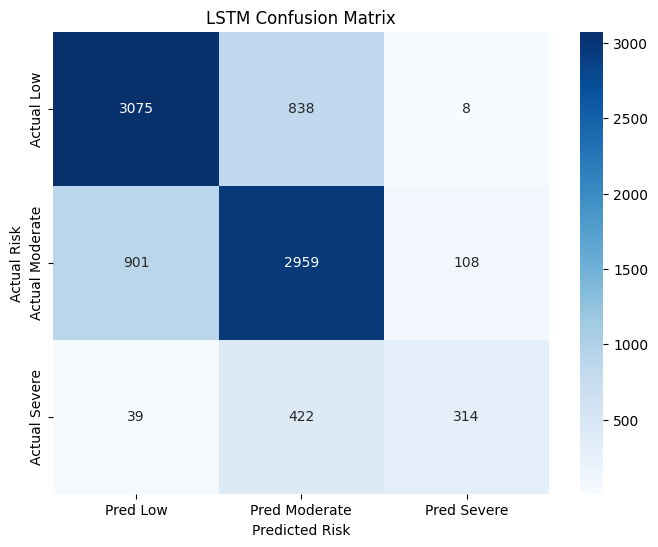

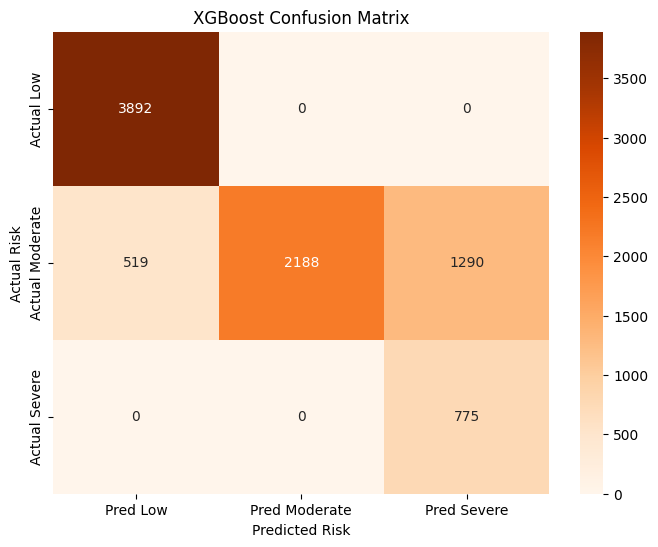


✅ LSTM Classification Report:

              precision    recall  f1-score   support

         Low       0.77      0.78      0.77      3921
    Moderate       0.70      0.75      0.72      3968
      Severe       0.73      0.41      0.52       775

    accuracy                           0.73      8664
   macro avg       0.73      0.65      0.67      8664
weighted avg       0.73      0.73      0.73      8664


✅ XGBoost Classification Report:

              precision    recall  f1-score   support

         Low       0.88      1.00      0.94      3892
    Moderate       1.00      0.55      0.71      3997
      Severe       0.38      1.00      0.55       775

    accuracy                           0.79      8664
   macro avg       0.75      0.85      0.73      8664
weighted avg       0.89      0.79      0.80      8664


✅ Sensitivity and Specificity Summary:
     Model     Class  Sensitivity  Specificity
0     LSTM       Low       0.7842       0.8018
1     LSTM  Moderate       0.7457    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Step 7.2 Misclassification rate comparison
# ✅ Step 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 2: Load XGBoost predictions and ground truth from CSV
xgb_df = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")
xgb_preds = xgb_df["Predicted_Risk"].values
xgb_true_labels = xgb_df["Actual_Risk"].values

# Ensure that X_val_lstm is in float32 format
X_val_lstm = X_val_lstm.astype(np.float32)

# ✅ Get LSTM Predictions
lstm_probs = lstm_model.predict(X_val_lstm)  # Probabilities for Low, Moderate, Severe
lstm_preds = np.argmax(lstm_probs, axis=1)  # Convert to class labels


# ✅ Step 4: Get the true labels used in LSTM validation (true y_val source!)
if y_val_lstm.ndim == 2:
    lstm_true_labels = np.argmax(y_val_lstm, axis=1)
else:
    lstm_true_labels = y_val_lstm.copy()

# ✅ Step 5: Sanity check - make sure LSTM metrics match model.evaluate
print("\n✅ Classification report directly using LSTM validation set:")
print(classification_report(lstm_true_labels, lstm_preds, target_names=["Low", "Moderate", "Severe"]))

# ✅ Step 6: Align lengths just in case
min_len = min(len(lstm_preds), len(xgb_preds), len(lstm_true_labels), len(xgb_true_labels))

lstm_preds_trimmed = lstm_preds[:min_len]
xgb_preds_trimmed = xgb_preds[:min_len]
lstm_true_trimmed = lstm_true_labels[:min_len]
xgb_true_trimmed = xgb_true_labels[:min_len]

# ✅ Step 7: Create DataFrames
df_lstm = pd.DataFrame({
    "LSTM_Predicted_Risk": lstm_preds_trimmed,
    "Actual_Risk_LSTM": lstm_true_trimmed
})
df_xgb = pd.DataFrame({
    "XGBoost_Predicted_Risk": xgb_preds_trimmed,
    "Actual_Risk_XGB": xgb_true_trimmed
})

# ✅ Step 8: Compare on same label reference (only if they're equal)
if np.array_equal(lstm_true_trimmed, xgb_true_trimmed):
    common_true_labels = lstm_true_trimmed
    print("✅ Ground truth labels are aligned. Proceeding with comparison.")
else:
    print("⚠️ Labels differ. Each model will be evaluated against its own ground truth.")
    common_true_labels = None  # for safety

# ✅ Step 9: Plot confusion matrices
cm_lstm = confusion_matrix(lstm_true_trimmed, lstm_preds_trimmed)
cm_xgb = confusion_matrix(xgb_true_trimmed, xgb_preds_trimmed)

cm_lstm_df = pd.DataFrame(cm_lstm, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                          columns=["Pred Low", "Pred Moderate", "Pred Severe"])
cm_xgb_df = pd.DataFrame(cm_xgb, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                         columns=["Pred Low", "Pred Moderate", "Pred Severe"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm_df, annot=True, fmt="d", cmap="Blues")
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_df, annot=True, fmt="d", cmap="Oranges")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.show()

# ✅ Step 10: Misclassification Comparison (only if aligned)
if common_true_labels is not None:
    merged_df = pd.DataFrame({
        "Actual_Risk": common_true_labels,
        "LSTM_Predicted_Risk": lstm_preds_trimmed,
        "XGBoost_Predicted_Risk": xgb_preds_trimmed
    })
    mismatch_df = merged_df[
        (merged_df["LSTM_Predicted_Risk"] != merged_df["Actual_Risk"]) &
        (merged_df["XGBoost_Predicted_Risk"] != merged_df["Actual_Risk"])
    ]
    print("✅ Sample of Cases Where LSTM and XGBoost Made Different Errors:\n")
    print(mismatch_df.head())

# ✅ Step 11: Individual Classification Reports
print("\n✅ LSTM Classification Report:\n")
print(classification_report(lstm_true_trimmed, lstm_preds_trimmed, target_names=["Low", "Moderate", "Severe"]))

print("\n✅ XGBoost Classification Report:\n")
print(classification_report(xgb_true_trimmed, xgb_preds_trimmed, target_names=["Low", "Moderate", "Severe"]))

# Step 11.1 Sensitivity and Specificity
from sklearn.metrics import confusion_matrix

def compute_sens_spec(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    metrics = []

    for i, label in enumerate(["Low", "Moderate", "Severe"]):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        metrics.append({
            "Model": model_name,
            "Class": label,
            "Sensitivity": round(sensitivity, 4),
            "Specificity": round(specificity, 4)
        })

    return pd.DataFrame(metrics)

# ✅ Calculate for both models
df_lstm_metrics = compute_sens_spec(lstm_true_trimmed, lstm_preds_trimmed, "LSTM")
df_xgb_metrics = compute_sens_spec(xgb_true_trimmed, xgb_preds_trimmed, "XGBoost")

# ✅ Combine and show
df_all = pd.concat([df_lstm_metrics, df_xgb_metrics])
print("\n✅ Sensitivity and Specificity Summary:")
print(df_all)

# ✅ Support values for each class
def get_support(cm):
    return {
        "Low": cm[0, :].sum(),
        "Moderate": cm[1, :].sum(),
        "Severe": cm[2, :].sum()
    }

# ✅ Function to compute overall weighted metrics
def compute_overall_sens_spec(metrics_df, support_dict):
    total = sum(support_dict.values())
    weighted_sens = sum(metrics_df.loc[i, "Sensitivity"] * support_dict[c] for i, c in enumerate(support_dict)) / total
    weighted_spec = sum(metrics_df.loc[i, "Specificity"] * support_dict[c] for i, c in enumerate(support_dict)) / total
    return round(weighted_sens * 100, 2), round(weighted_spec * 100, 2)

# ✅ Get supports and calculate for both models
lstm_support = get_support(confusion_matrix(lstm_true_trimmed, lstm_preds_trimmed))
xgb_support = get_support(confusion_matrix(xgb_true_trimmed, xgb_preds_trimmed))

lstm_overall_sens, lstm_overall_spec = compute_overall_sens_spec(df_lstm_metrics, lstm_support)
xgb_overall_sens, xgb_overall_spec = compute_overall_sens_spec(df_xgb_metrics, xgb_support)

# ✅ Print results
print(f"\n✅ LSTM Overall Sensitivity: {lstm_overall_sens:.2f}%, Specificity: {lstm_overall_spec:.2f}%")
print(f"✅ XGBoost Overall Sensitivity: {xgb_overall_sens:.2f}%, Specificity: {xgb_overall_spec:.2f}%")

# ✅ Step 12: Save for Ensemble Reuse
np.save("lstm_preds_trimmed.npy", lstm_preds_trimmed)
np.save("xgb_preds_trimmed.npy", xgb_preds_trimmed)
np.save("lstm_true_trimmed.npy", lstm_true_trimmed)
np.save("xgb_true_trimmed.npy", xgb_true_trimmed)

files.download("lstm_preds_trimmed.npy")
files.download("xgb_preds_trimmed.npy")
files.download("lstm_true_trimmed.npy")
files.download("xgb_true_trimmed.npy")

In [ ]:
# Step 8 ✅ Load XGBoost dataset
val_xgb = pd.read_csv("val_XGBoost.csv")

# ✅ Extract feature list for XGBoost (excluding target variable)
xgb_features = val_xgb.drop(columns=['Max_Risk_Quartile']).columns.tolist()

# ✅ Load LSTM dataset and get feature count
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
lstm_feature_count = X_val_lstm.shape[2]  # Number of features in LSTM

# ✅ Print feature lists for comparison
print("✅ XGBoost Features:", xgb_features)
print(f"✅ LSTM Feature Count: {lstm_feature_count}")

# ✅ Check if feature counts match
if len(xgb_features) == lstm_feature_count:
    print("✅ LSTM and XGBoost feature counts match.")
else:
    print("⚠️ Feature count mismatch! Double-check preprocessing steps.")


✅ XGBoost Features: ['Altimeter_Lag_3', 'Precipitation_Lag_3', 'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3', 'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Max_Risk_Quartile_Lag_3', 'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3', 'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
✅ LSTM Feature Count: 19
⚠️ Feature count mismatch! Double-check preprocessing steps.


In [ ]:
# Step 8.1 reload data
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# ✅ Reload trained models
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Reload validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)

# ✅ Reload XGBoost validation data with categorical risk predictions
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Print confirmation
print("✅ Reloaded all necessary data for ROC Curve.")


✅ Reloaded all necessary data for ROC Curve.


In [ ]:
#Step 8.1.2 Regenerate the model for timeline, ensure correct ensemble script
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import joblib
from sklearn.linear_model import LogisticRegression

# ✅ Load LSTM model and XGBoost model
lstm_model = load_model("LSTM_Trained_Model.keras")
xgb_model = joblib.load("xgb_tuned_quartile_model.pkl")

# ✅ Load validation inputs
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True).astype(np.float32)
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Generate LSTM class probabilities
lstm_probs = lstm_model.predict(X_val_lstm)  # shape: (n_samples, 3)

# ✅ Generate XGBoost one-hot probabilities from categorical predictions
xgb_probs = np.zeros((len(val_xgb), 3))
for i, pred in enumerate(val_xgb["Predicted_Risk"]):
    xgb_probs[i, pred] = 1

# ✅ Trim to match lengths if needed
min_len = min(len(lstm_probs), len(xgb_probs))
lstm_probs = lstm_probs[-min_len:]
xgb_probs = xgb_probs[-min_len:]

# ✅ Concatenate LSTM + XGBoost probabilities to use as meta features
meta_X = np.hstack((lstm_probs, xgb_probs))  # shape: (n_samples, 6)

# ✅ Load true labels for training meta-model
# Ensure this matches the aligned validation samples
meta_y = val_xgb["Actual_Risk"].values[-min_len:]  # Assuming 0=Low, 1=Moderate, 2=Severe

# ✅ Train logistic regression meta-model
meta_model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
meta_model.fit(meta_X, meta_y)

# ✅ Make final predictions
final_preds = meta_model.predict(meta_X)

# Optional: Save the meta-model
joblib.dump(meta_model, "logistic_meta_ensemble.pkl")

271/271 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


['logistic_meta_ensemble.pkl']

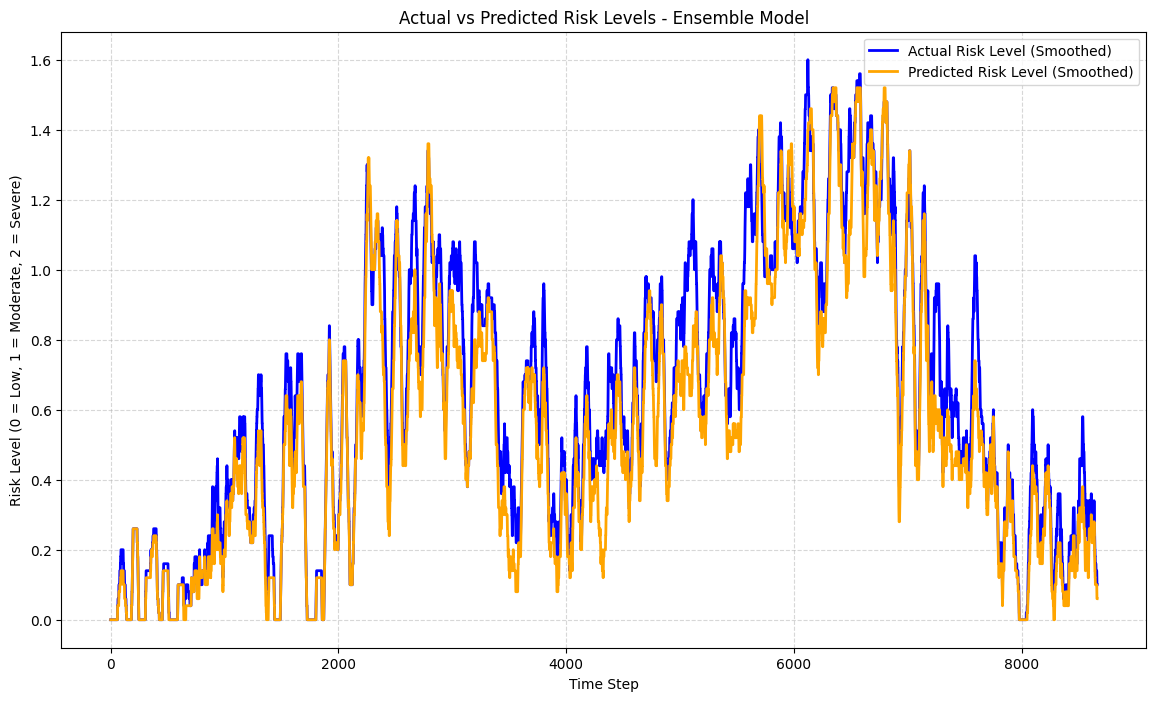

In [ ]:
#Step 8.3 Timeline
# ✅ Step 6: Graph - Actual vs. Predicted Risk Levels (Ensemble Model)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# ✅ Reload validation labels
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)

# ✅ Reload saved ensemble model and extract predictions
meta_model = joblib.load("final_meta_ensemble_model.pkl")
#final_preds = meta_model.predict(meta_X)  # Generate final predictions from the ensemble model


# ✅ Convert one-hot encoded y_val_lstm back to class labels
y_true_class = np.argmax(y_val_lstm, axis=1)

# ✅ Ensure both arrays are the same length
if len(y_true_class) != len(final_preds):
    min_length = min(len(y_true_class), len(final_preds))
    y_true_class = y_true_class[:min_length]
    final_preds = final_preds[:min_length]

# ✅ Create DataFrame for visualization
results_df = pd.DataFrame({
    'Time Step': np.arange(len(y_true_class)),  # Sequential index
    'Actual Risk Level': y_true_class,
    'Predicted Risk Level': final_preds
})

# ✅ Apply rolling mean for smoother trend visualization
rolling_window = 50  # Adjust window size for more or less smoothing
results_df['Actual Risk (Smoothed)'] = results_df['Actual Risk Level'].rolling(window=rolling_window, min_periods=1).mean()
results_df['Predicted Risk (Smoothed)'] = results_df['Predicted Risk Level'].rolling(window=rolling_window, min_periods=1).mean()

# ✅ Plot the smoothed actual vs. predicted risk levels
plt.figure(figsize=(14, 8))
plt.plot(results_df['Time Step'], results_df['Actual Risk (Smoothed)'], label='Actual Risk Level (Smoothed)', linewidth=2, color='blue')
plt.plot(results_df['Time Step'], results_df['Predicted Risk (Smoothed)'], label='Predicted Risk Level (Smoothed)', linewidth=2, color='orange')

# ✅ Formatting and Labels
plt.xlabel('Time Step')
plt.ylabel('Risk Level (0 = Low, 1 = Moderate, 2 = Severe)')
plt.title('Actual vs Predicted Risk Levels - Ensemble Model')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# ✅ Show the plot
plt.show()





In [ ]:
# Step 9.1 ✅ Trim XGBoost predictions to match LSTM sample count
xgb_probs = xgb_probs[-8664:]


In [ ]:
# Step 9.2 ROC from sklearn.metrics import roc_curve, auc
# ✅ Compute ensemble probabilities (Weighted Fusion)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# ✅ Convert true labels back from one-hot encoding
y_true = np.argmax(y_val_lstm, axis=1)

# ✅ Plot ROC Curve for each class
plt.figure(figsize=(10, 6))

for i, label in enumerate(["Low", "Moderate", "Severe"]):
    fpr, tpr, _ = roc_curve(y_true == i, ensemble_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} Risk (AUC = {roc_auc:.3f})")

# ✅ Finalize ROC Curve Plot
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Logistic Regression Ensemble")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



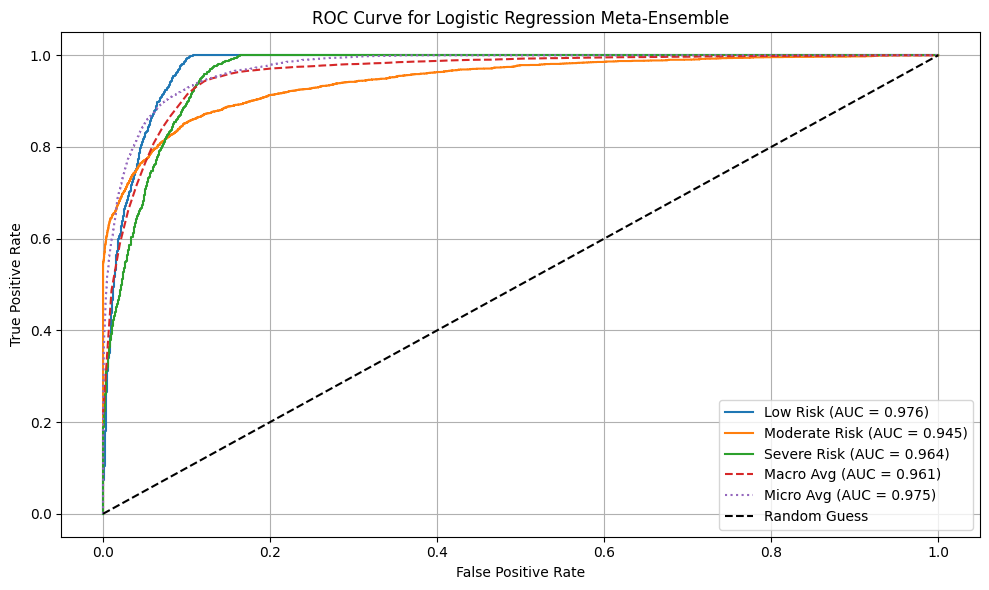

In [ ]:
# Step 9.3 Composite ROC
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# ✅ Use logistic regression meta-model to get predicted probabilities
meta_probs = meta_model.predict_proba(meta_X)

# ✅ Convert true labels to one-hot encoding for ROC
y_true_bin = label_binarize(meta_y, classes=[0, 1, 2])  # Ensure same order: Low, Moderate, Severe

# ✅ Compute ROC curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(["Low", "Moderate", "Severe"]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], meta_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ✅ Macro-Averaged ROC (Mean of class-wise interpolated TPR)
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(len(fpr)):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= len(fpr)
roc_auc_macro = auc(fpr_macro, tpr_macro)

# ✅ Micro-Averaged ROC (Flatten all classes)
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), meta_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# ✅ Plot ROC Curves
plt.figure(figsize=(10, 6))

for i, label in enumerate(["Low", "Moderate", "Severe"]):
    plt.plot(fpr[i], tpr[i], label=f"{label} Risk (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr_macro, tpr_macro, linestyle="dashed", label=f"Macro Avg (AUC = {roc_auc_macro:.3f})")
plt.plot(fpr_micro, tpr_micro, linestyle="dotted", label=f"Micro Avg (AUC = {roc_auc_micro:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression Meta-Ensemble")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Step 9.4 features list development
import joblib
import pandas as pd

# ✅ Reload training data to get column names
train_xgb = pd.read_csv("train_XGBoost.csv")
xgb_feature_names = [col for col in train_xgb.columns if col in xgb_model.feature_names_in_]

# ✅ Check the number of features stored in the XGBoost model
num_xgb_features = len(xgb_model.feature_importances_)
print(f"✅ XGBoost model was trained with {num_xgb_features} features.")

# ✅ Check the extracted feature names count
print(f"✅ Extracted {len(xgb_feature_names)} feature names.")

# ✅ Print for debugging
print("✅ Feature names extracted:", xgb_feature_names)

✅ XGBoost model was trained with 17 features.
✅ Extracted 17 feature names.
✅ Feature names extracted: ['Altimeter_Lag_3', 'Precipitation_Lag_3', 'Humidity_Lag_3', 'Visibility_Lag_3', 'Wet_Bulb_Lag_3', 'Wind_Speed_Lag_3', 'Wind_Direction_Lag_3', 'Max_Risk_Quartile_Lag_3', 'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3', 'Sky_Cond_Few_Lag_3', 'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [ ]:
# Step 9.5 ✅ Trim the extracted feature list to match the number of features XGBoost actually used
xgb_feature_names = xgb_feature_names[:num_xgb_features]

# ✅ Ensure feature count now matches
if len(xgb_feature_names) == len(xgb_model.feature_importances_):
    print("✅ XGBoost feature count now matches!")
else:
    print("⚠️ Still a mismatch! Need to check preprocessing steps.")


✅ XGBoost feature count now matches!


In [ ]:
import pandas as pd

# Load the dataset
train_xgb = pd.read_csv("train_XGBoost.csv")

# Check if the lag features already exist
print(train_xgb.head())  # Show the first few rows
print("Columns in dataset:", train_xgb.columns.tolist())


   Max_Risk_Quartile  Altimeter_Lag_3  Precipitation_Lag_3  Humidity_Lag_3  \
0                  0         0.766234                  0.0        0.703297   
1                  0         0.772727                  0.0        0.725275   
2                  0         0.766234                  0.0        0.736264   
3                  0         0.753247                  0.0        0.670330   
4                  0         0.746753                  0.0        0.725275   

   Visibility_Lag_3  Wet_Bulb_Lag_3  Wind_Speed_Lag_3  Wind_Direction_Lag_3  \
0               1.0        0.352113          0.128205              0.916667   
1               1.0        0.352113          0.153846              0.902778   
2               1.0        0.323944          0.153846              0.916667   
3               1.0        0.323944          0.000000              0.000000   
4               1.0        0.309859          0.205128              0.916667   

   Max_Risk_Quartile_Lag_3  Sky_Cond_Broken_Lag_3  Sky_C

In [ ]:
#Step 9.6 Feature list for XGBoost
import joblib
import pandas as pd

# ✅ Load trained XGBoost model
xgb_model_path = "xgb_tuned_quartile_model.pkl"
xgb_tuned = joblib.load(xgb_model_path)

# ✅ Load the training data used for feature names
train_xgb = pd.read_csv("train_XGBoost.csv")

# ✅ Drop the target column to get only feature names
xgb_feature_names = train_xgb.drop(columns=["Max_Risk_Quartile"]).columns.tolist()

# ✅ Create feature importance DataFrame
xgb_feature_importance = pd.DataFrame({
    'Feature': xgb_feature_names,
    'Importance_XGBoost': xgb_tuned.feature_importances_
}).sort_values(by='Importance_XGBoost', ascending=False)

# ✅ Save to CSV
xgb_feature_path = "/content/XGBoost_Feature_Importance.csv"
xgb_feature_importance.to_csv(xgb_feature_path, index=False)

print(f"✅ XGBoost Feature Importance saved to: {xgb_feature_path}")

# ✅ Download
from google.colab import files
files.download(xgb_feature_path)

✅ XGBoost Feature Importance saved to: /content/XGBoost_Feature_Importance.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ x_val_LSTM dtype fixed: float64, shape: (8664, 96, 19)
✅ y_val_LSTM dtype fixed: float64, shape: (8664, 3)
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 14

<ipython-input-50-6901d2d3e714>:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


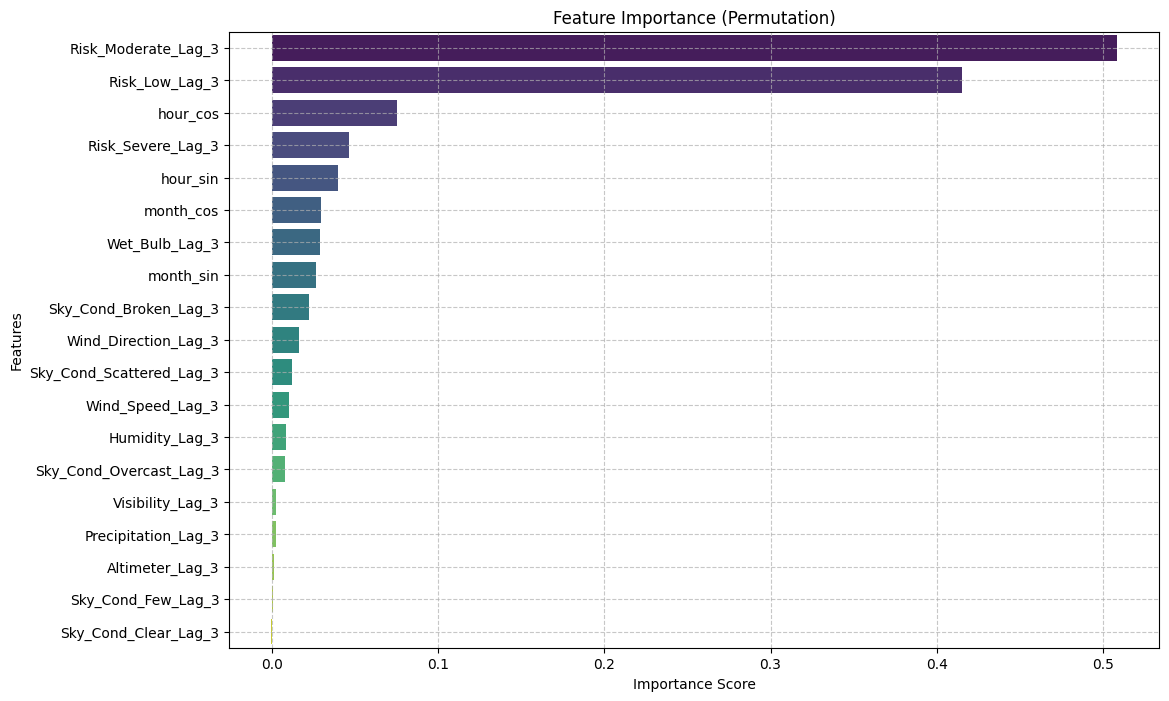

Feature importances saved to: /content/LSTM_Feature_Importance.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 9.7 LSTM RNN Feature selection using a COLAB runtime
# Custom Feature list through permutation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# ✅ File Paths
model_path = "LSTM_Trained_Model.keras"

# ✅ Load the Trained LSTM Model
model = load_model(model_path)

# ✅ Load validation data
x_val_LSTM = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val_LSTM = np.load("y_val_LSTM.npy", allow_pickle=True)

# Ensure all elements in x_val_LSTM are numeric arrays
x_val_LSTM_fixed = np.array(x_val_LSTM.tolist(), dtype=np.float64)

# Convert y_val_LSTM to float32 (recommended for deep learning models)
y_val_LSTM_fixed = y_val_LSTM.astype("float64")

# Verify the new data types
print(f"✅ x_val_LSTM dtype fixed: {x_val_LSTM_fixed.dtype}, shape: {x_val_LSTM_fixed.shape}")
print(f"✅ y_val_LSTM dtype fixed: {y_val_LSTM_fixed.dtype}, shape: {y_val_LSTM_fixed.shape}")

# ✅ Feature List
feature_columns = ['Altimeter_Lag_3', 'Precipitation_Lag_3', 'Humidity_Lag_3',
                   'Visibility_Lag_3', 'Wet_Bulb_Lag_3', 'Wind_Speed_Lag_3',
                   'Wind_Direction_Lag_3', 'Risk_Low_Lag_3', 'Risk_Moderate_Lag_3',
                   'Risk_Severe_Lag_3', 'Sky_Cond_Broken_Lag_3', 'Sky_Cond_Clear_Lag_3',
                   'Sky_Cond_Few_Lag_3', 'Sky_Cond_Overcast_Lag_3', 'Sky_Cond_Scattered_Lag_3',
                   'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


#Correct feature order from Feature_LSTM_Column: 'Wet_Bulb_Lag_2', 'Wet_Bulb_Lag_3', 'Wind_Speed_Lag_2', 'Altimeter_Lag_3', 'Risk_Low_Lag_2', 'Risk_Low_Lag_24', 'Risk_Moderate_Lag_2', 'Risk_Moderate_Lag_24', 'Risk_Severe_Lag_2', 'Risk_Severe_Lag_24', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'

# ✅ Ensure correct number of features
num_features = x_val_LSTM.shape[2]
if len(feature_columns) != num_features:
    raise ValueError(f"Feature mismatch: Expected {num_features} features, got {len(feature_columns)}.")

# ✅ Permutation Importance Function
def custom_permutation_importance(model, X, y, metric=accuracy_score, feature_names=None, num_repeats=10):
    baseline_score = metric(np.argmax(y, axis=1), np.argmax(model.predict(X), axis=1))
    feature_importances = []

    for col_idx in range(X.shape[2]):
        scores = []
        for _ in range(num_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, :, col_idx])  # Shuffle the entire column
            permuted_score = metric(np.argmax(y, axis=1), np.argmax(model.predict(X_permuted), axis=1))
            scores.append(baseline_score - permuted_score)

        feature_importances.append(np.mean(scores))

    return pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# ✅ Compute Permutation Importance
importance_df = custom_permutation_importance(
    model, x_val_LSTM_fixed, y_val_LSTM_fixed, metric=accuracy_score, feature_names=feature_columns, num_repeats=10
)


# ✅ Plot Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title("Feature Importance (Permutation)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# ✅ Save Results
output_path = "/content/LSTM_Feature_Importance.csv"
importance_df.to_csv(output_path, index=False)

print(f"Feature importances saved to: {output_path}")

# ✅ Download the file manually
from google.colab import files
files.download(output_path)


In [ ]:
#Step 9.8 make features list match
import numpy as np

# Ensure all elements in x_val_LSTM are numeric arrays
x_val_LSTM_fixed = np.array(x_val_LSTM.tolist(), dtype=np.float64)

# Convert y_val_LSTM to float32 (recommended for deep learning models)
y_val_LSTM_fixed = y_val_LSTM.astype("float64")

# Verify the new data types
print(f"✅ x_val_LSTM dtype fixed: {x_val_LSTM_fixed.dtype}, shape: {x_val_LSTM_fixed.shape}")
print(f"✅ y_val_LSTM dtype fixed: {y_val_LSTM_fixed.dtype}, shape: {y_val_LSTM_fixed.shape}")


✅ x_val_LSTM dtype fixed: float64, shape: (8664, 96, 19)
✅ y_val_LSTM dtype fixed: float64, shape: (8664, 3)


Combined the features lists from both and used the champion ensemble percentages to create a new champion model feature list.

In [ ]:
from google.colab import files
files.upload()

In [ ]:
from google.colab import files
files.upload()

✅ Successfully loaded both feature importance files!


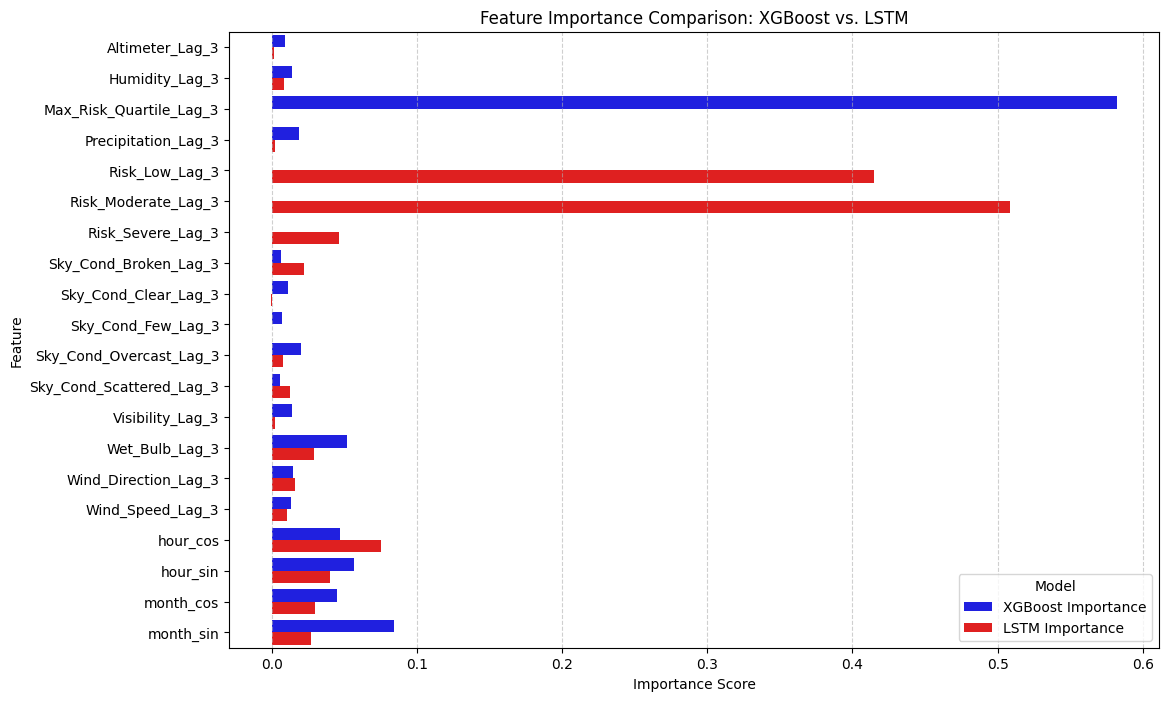

<ipython-input-52-aedafda9a086>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


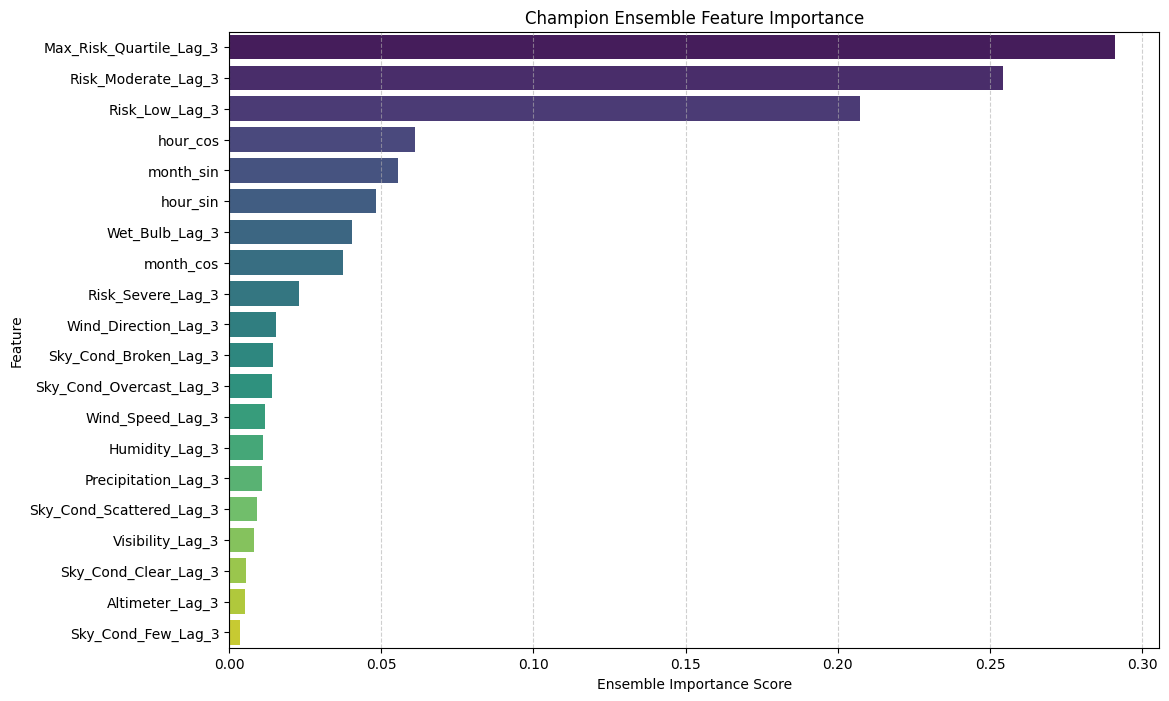


✅ Ensemble Feature Importance saved to: /content/Ensemble_Feature_Importance.csv


In [ ]:
# step 9.8.1 merge the feature importance into one file
import pandas as pd

xgb_importance_df = pd.read_csv("XGBoost_Feature_Importance.csv")
lstm_importance_df = pd.read_csv("LSTM_Feature_Importance.csv")

print("✅ Successfully loaded both feature importance files!")

# ✅ Merge XGBoost & LSTM Feature Importance
merged_importance_df = pd.merge(
    xgb_importance_df, lstm_importance_df, on="Feature", how="outer"
).fillna(0)

# ✅ Rename columns for clarity
merged_importance_df.rename(columns={"Importance_XGBoost": "XGBoost Importance", "Importance": "LSTM Importance"}, inplace=True)

# ✅ Bar Chart: XGBoost vs. LSTM Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(
    data=merged_importance_df.melt(id_vars="Feature", var_name="Model", value_name="Importance"),
    x="Importance", y="Feature", hue="Model", palette=["blue", "red"]
)
plt.title("Feature Importance Comparison: XGBoost vs. LSTM")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.legend(title="Model")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

# ✅ Compute & Plot Champion Ensemble Feature Importance
merged_importance_df["Ensemble Importance"] = (merged_importance_df["XGBoost Importance"] + merged_importance_df["LSTM Importance"]) / 2

plt.figure(figsize=(12, 8))
sns.barplot(
    x="Ensemble Importance", y="Feature", data=merged_importance_df.sort_values(by="Ensemble Importance", ascending=False),
    palette="viridis"
)
plt.title("Champion Ensemble Feature Importance")
plt.xlabel("Ensemble Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

# ✅ Save Final Ensemble Feature Importance
ensemble_feature_path = "/content/Ensemble_Feature_Importance.csv"
merged_importance_df.to_csv(ensemble_feature_path, index=False)

# ✅ Confirm File Save
print(f"\n✅ Ensemble Feature Importance saved to: {ensemble_feature_path}")


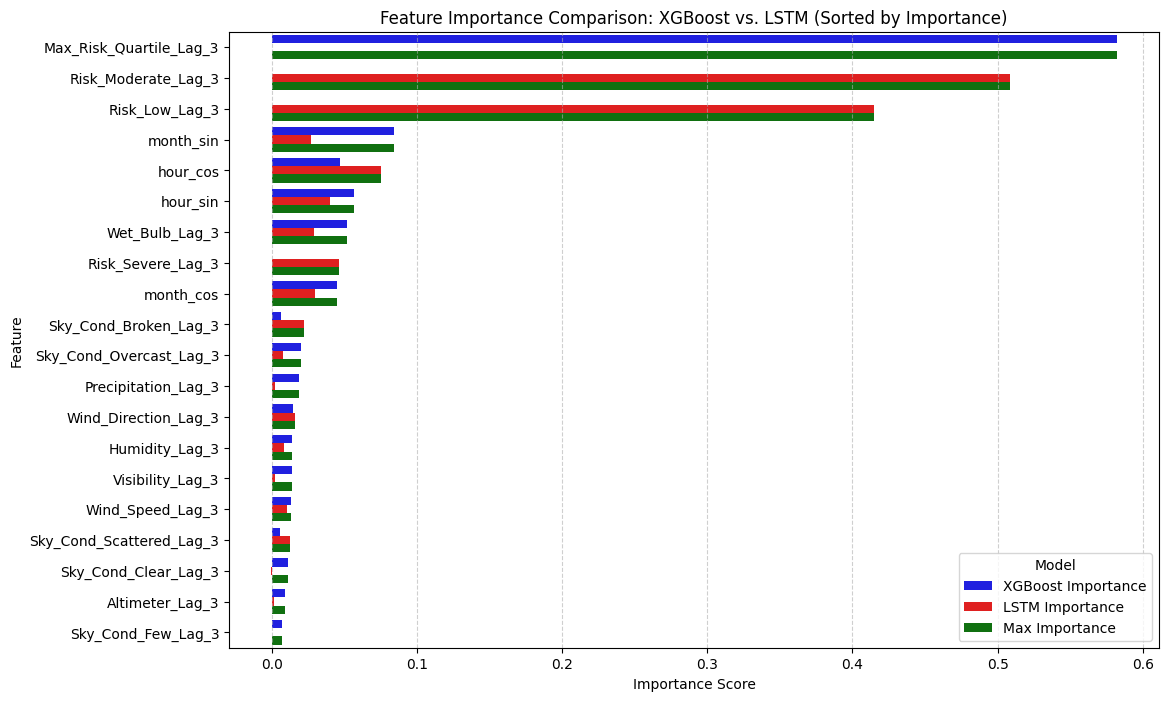

<ipython-input-53-f82977a5a5e0>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


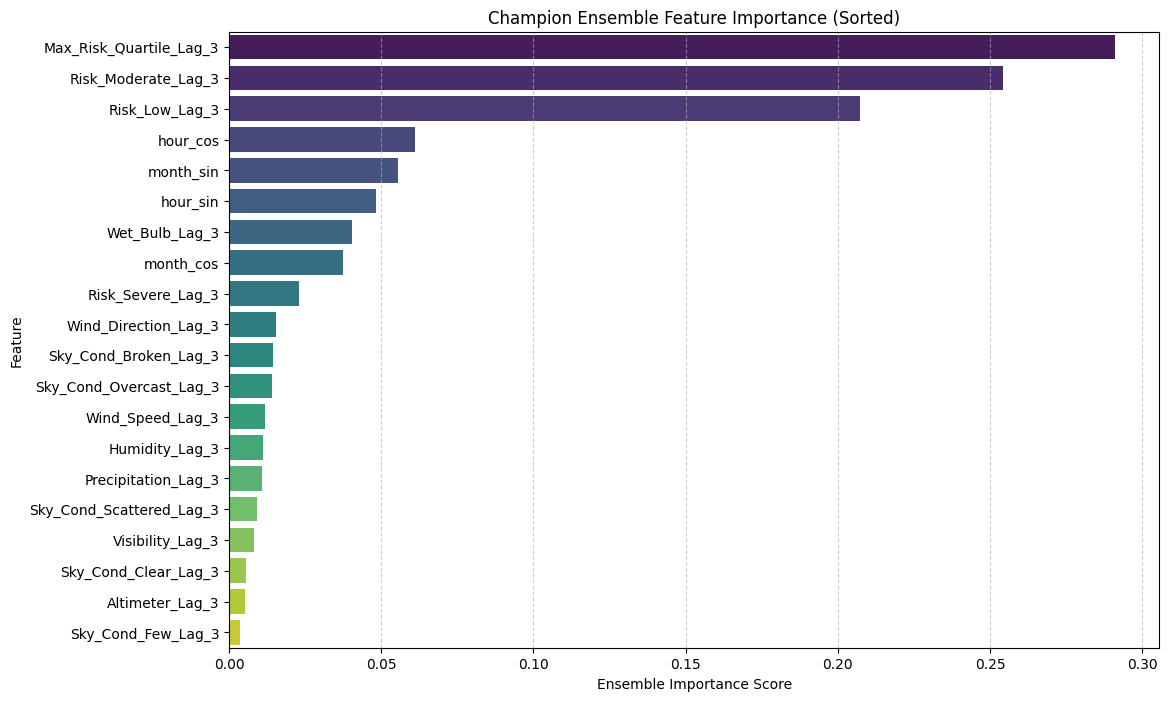

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Champion Ensemble Feature Importance Table (Sorted):
                 Feature  XGBoost Importance  LSTM Importance  Max Importance  Ensemble Importance
 Max_Risk_Quartile_Lag_3            0.582101         0.000000        0.582101             0.291050
     Risk_Moderate_Lag_3            0.000000         0.508310        0.508310             0.254155
          Risk_Low_Lag_3            0.000000         0.414912        0.414912             0.207456
               month_sin            0.084323         0.026824        0.084323             0.055574
                hour_cos            0.047022         0.075219        0.075219             0.061121
                hour_sin            0.056415         0.039820        0.056415             0.048118
          Wet_Bulb_Lag_3            0.051709         0.029074        0.051709             0.040392
       Risk_Severe_Lag_3            0.000000         0.046226        0.046226             0.023113
               month_cos            0.044797         

In [ ]:
#Step 9.8.2 More in depth feature analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load XGBoost and LSTM Feature Importance Files
xgb_importance_df = pd.read_csv("XGBoost_Feature_Importance.csv")
lstm_importance_df = pd.read_csv("LSTM_Feature_Importance.csv")

# ✅ Merge XGBoost & LSTM Feature Importance
merged_importance_df = pd.merge(
    xgb_importance_df, lstm_importance_df, on="Feature", how="outer"
).fillna(0)  # Fill missing values with 0 if a feature is missing from one model

# ✅ Rename columns for clarity
merged_importance_df.rename(columns={"Importance_XGBoost": "XGBoost Importance", "Importance": "LSTM Importance"}, inplace=True)

# ✅ Compute a sorting metric (Maximum Importance from Both Models)
merged_importance_df["Max Importance"] = merged_importance_df[["XGBoost Importance", "LSTM Importance"]].max(axis=1)

# ✅ Sort by this new ranking metric
merged_importance_df_sorted = merged_importance_df.sort_values(by="Max Importance", ascending=False)

# ✅ Plot Sorted Side-by-Side Feature Importance Chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=merged_importance_df_sorted.melt(id_vars="Feature", var_name="Model", value_name="Importance"),
    x="Importance", y="Feature", hue="Model", palette=["blue", "red", "green"]
)
plt.title("Feature Importance Comparison: XGBoost vs. LSTM (Sorted by Importance)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.legend(title="Model")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

# ✅ Compute Champion Ensemble Feature Importance (Weighted Average)
merged_importance_df_sorted["Ensemble Importance"] = (
    merged_importance_df_sorted["XGBoost Importance"] + merged_importance_df_sorted["LSTM Importance"]
) / 2

# ✅ Plot Sorted Champion Ensemble Feature Importance Chart
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Ensemble Importance", y="Feature",
    data=merged_importance_df_sorted.sort_values(by="Ensemble Importance", ascending=False),
    palette="viridis"
)
plt.title("Champion Ensemble Feature Importance (Sorted)")
plt.xlabel("Ensemble Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

# ✅ Save Merged Feature Importance Table
ensemble_feature_path = "Ensemble_Feature_Importance_Sorted.csv"
merged_importance_df_sorted.to_csv(ensemble_feature_path, index=False)

# ✅ Provide download link
import google.colab.files
google.colab.files.download(ensemble_feature_path)

# ✅ Display the final sorted feature importance table
print("\n✅ Champion Ensemble Feature Importance Table (Sorted):")
print(merged_importance_df_sorted.to_string(index=False))

print(f"\n✅ Ensemble Feature Importance saved to: {ensemble_feature_path}")


Utilized bootstrapping the two individual models with 1000 iterations to find the confidence interval of each individual model, then used the same ensemble method to determine the final confidence interval.

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Step 10 Create files for CI
import numpy as np
import pandas as pd

# ✅ Load XGBoost validation data
val_xgb = pd.read_csv("val_XGBoost.csv")

# ✅ Extract feature columns (Ensure target 'Max_Risk_Quartile' is NOT included)
X_val_XGB = val_xgb.drop(columns=['Max_Risk_Quartile']).values  # Convert to NumPy array

# ✅ Save as `.npy` for compatibility with bootstrapping
np.save("X_val_XGB.npy", X_val_XGB)

print("✅ XGBoost validation data saved as X_val_XGB.npy!")

from google.colab import files
files.download("X_val_XGB.npy")
print("✅ XGBoost validation data downloaded as X_val_XGB.npy!")


✅ XGBoost validation data saved as X_val_XGB.npy!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ XGBoost validation data downloaded as X_val_XGB.npy!


In [ ]:
#Step 10.1 add dates to critical files
import pandas as pd

# ✅ Load source file with timestamp
preprocessed_df = pd.read_csv("ATL_XGBoost_Preprocessed.csv", parse_dates=["DATE_and_Time"])

# ✅ Load current categorical prediction file (missing date)
val_current = pd.read_csv("val_XGBoost_with_Categorical_Risk.csv")

# ✅ Sanity check: match row counts
assert len(preprocessed_df) >= len(val_current), "❌ Not enough rows in preprocessed file!"

# ✅ Extract the last N timestamps from the preprocessed file
# This assumes that validation data was the last portion of the full dataset (common in time-series)
val_timestamps = preprocessed_df["DATE_and_Time"].iloc[-len(val_current):].reset_index(drop=True)

# ✅ Attach timestamp column to current prediction file
val_current["DATE_and_Time"] = val_timestamps

# ✅ Save to new file
output_path = "val_XGBoost_with_Categorical_Risk_with_date.csv"
val_current.to_csv(output_path, index=False)

print(f"✅ DATE_and_Time successfully attached and saved to: {output_path}")
print(val_current[["DATE_and_Time", "Predicted_Risk"]].head())


✅ DATE_and_Time successfully attached and saved to: val_XGBoost_with_Categorical_Risk_with_date.csv
        DATE_and_Time  Predicted_Risk
0 2019-01-01 00:00:00               0
1 2019-01-01 01:00:00               0
2 2019-01-01 02:00:00               1
3 2019-01-01 03:00:00               1
4 2019-01-01 04:00:00               0


In [ ]:
# ✅ Provide download link
import google.colab.files
google.colab.files.download("val_XGBoost_with_Categorical_Risk_with_date.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

271/271 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step
✅ Full CI report saved to: Full_CI_with_LSTM_XGB_Ensemble.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔍 Avg CI Widths
Ensemble — Low: 1.0 | Moderate: 1.0 | Severe: 0.47804376775170176
LSTM     — Low: 1.0 | Moderate: 0.99467254 | Severe: 0.45223945
XGBoost  — Low: 1.0 | Moderate: 0.9999935621277187 | Severe: 0.9999163535212482


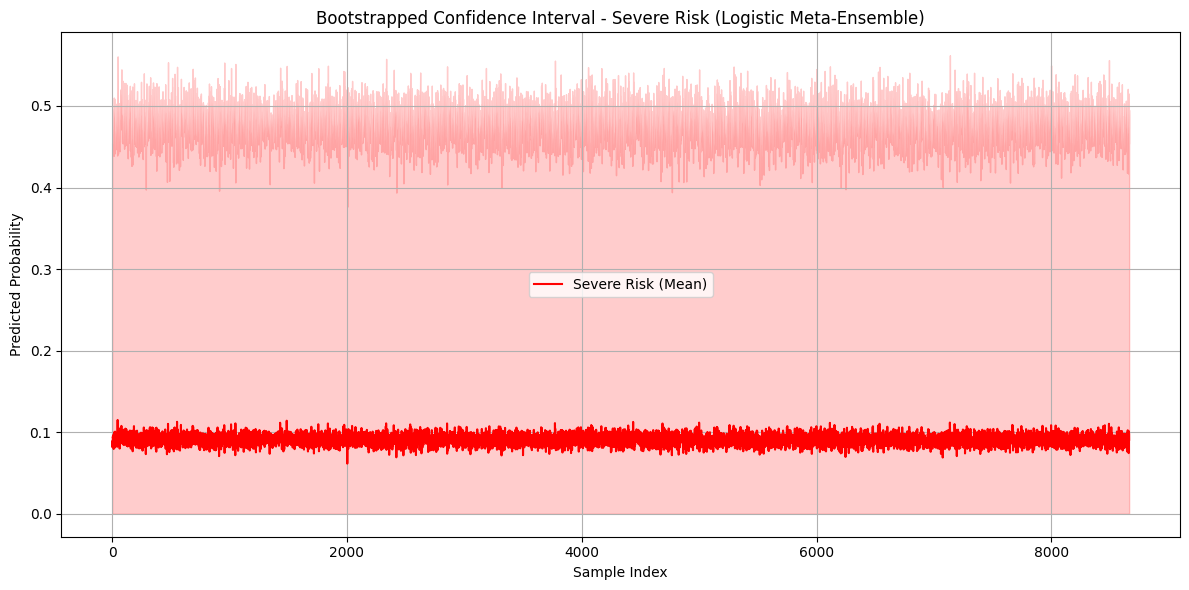

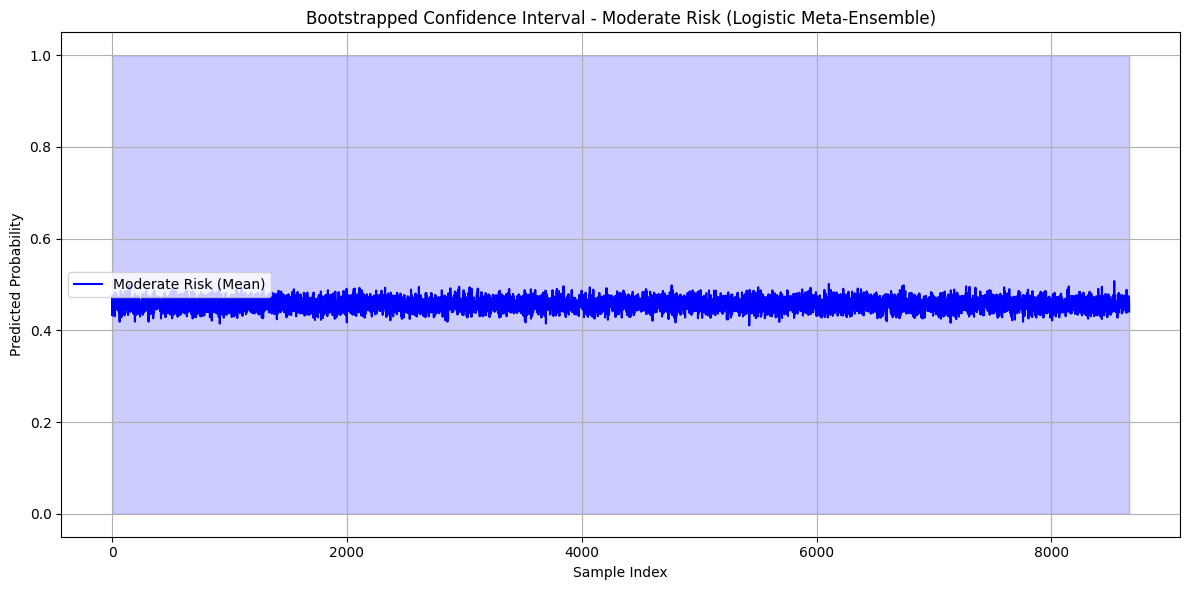

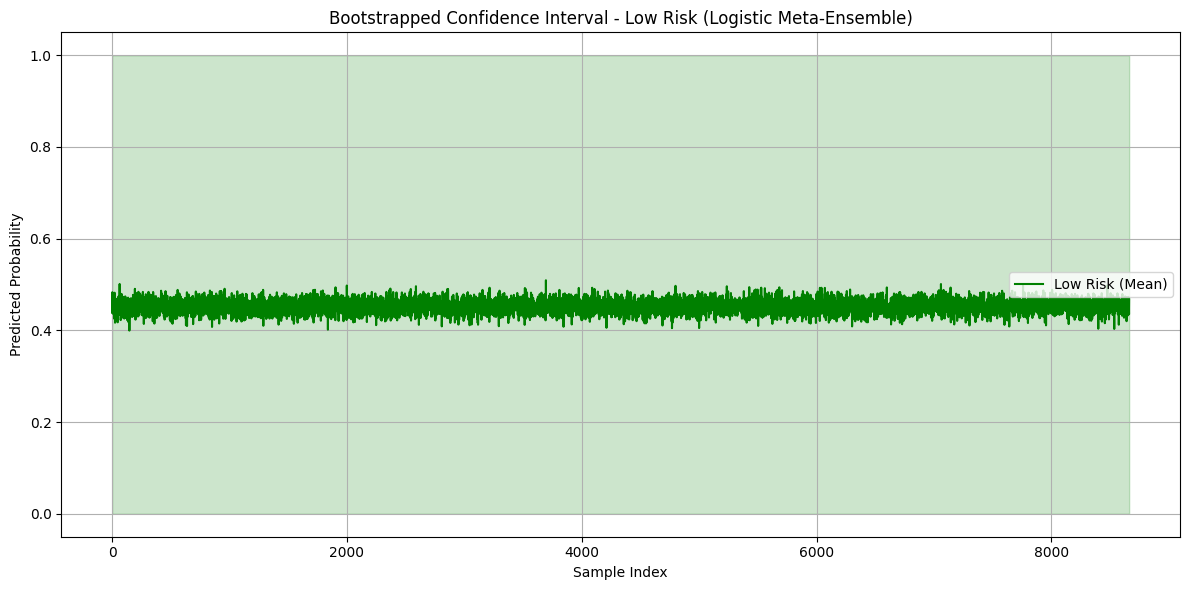

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Ensemble 2 CI bootstrapping complete!


In [ ]:
# ✅ Step 10.2: Bootstrap Confidence Intervals for Logistic Meta-Ensemble and Base Models
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize
import google.colab.files

# ✅ Load meta-model and base models
meta_model = joblib.load("final_meta_ensemble_model.pkl")
lstm_model = load_model("LSTM_Trained_Model.keras")

# ✅ Load validation data
X_val_lstm = np.load("X_val_LSTM.npy", allow_pickle=True).astype(np.float32)
lstm_probs = lstm_model.predict(X_val_lstm)

val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk_with_date.csv", parse_dates=["DATE_and_Time"])
xgb_preds = val_xgb["Predicted_Risk"].values

# ✅ Construct one-hot XGBoost probabilities
xgb_probs = np.zeros((len(xgb_preds), 3))
for i, pred in enumerate(xgb_preds):
    xgb_probs[i, pred] = 1

# ✅ Align lengths
min_len = min(len(lstm_probs), len(xgb_probs))
lstm_probs = lstm_probs[-min_len:]
xgb_probs = xgb_probs[-min_len:]
meta_X = np.hstack((lstm_probs, xgb_probs))

# ✅ Load and align metadata
raw_df = pd.read_excel("ATL_Data_Python_Imputed.xlsx", parse_dates=["DATE_and_Time"])
val_timestamps = val_xgb["DATE_and_Time"][-min_len:]
meta_metadata = raw_df[raw_df["DATE_and_Time"].isin(val_timestamps)].sort_values("DATE_and_Time").reset_index(drop=True)
meta_metadata = meta_metadata[-min_len:]
assert len(meta_metadata) == min_len, "❌ Metadata length mismatch!"

# ✅ Bootstrap parameters
n_bootstraps = 1000
z_score = 1.96

# ✅ Reusable function for bootstrapped CI
def bootstrap_ci(probs, label, n_bootstraps=1000, z_score=1.96):
    n_samples = probs.shape[0]
    sum_preds = np.zeros_like(probs)
    sum_preds_sq = np.zeros_like(probs)

    for _ in range(n_bootstraps):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        sample = probs[indices]
        sum_preds += sample
        sum_preds_sq += sample ** 2

    mean_preds = sum_preds / n_bootstraps
    std_preds = np.sqrt((sum_preds_sq / n_bootstraps) - (mean_preds ** 2))
    lower = np.clip(mean_preds - z_score * std_preds, 0, 1)
    upper = np.clip(mean_preds + z_score * std_preds, 0, 1)
    width = upper - lower

    return pd.DataFrame({
        f"Mean Prediction ({label} Low)": mean_preds[:, 0],
        f"Lower Bound ({label} Low 95% CI)": lower[:, 0],
        f"Upper Bound ({label} Low 95% CI)": upper[:, 0],
        f"{label} Low CI Width": width[:, 0],

        f"Mean Prediction ({label} Moderate)": mean_preds[:, 1],
        f"Lower Bound ({label} Moderate 95% CI)": lower[:, 1],
        f"Upper Bound ({label} Moderate 95% CI)": upper[:, 1],
        f"{label} Moderate CI Width": width[:, 1],

        f"Mean Prediction ({label} Severe)": mean_preds[:, 2],
        f"Lower Bound ({label} Severe 95% CI)": lower[:, 2],
        f"Upper Bound ({label} Severe 95% CI)": upper[:, 2],
        f"{label} Severe CI Width": width[:, 2]
    })

# ✅ Run CI bootstrap for all models
ensemble_probs = meta_model.predict_proba(meta_X)
ci_ensemble = bootstrap_ci(ensemble_probs, "Ensemble")
ci_lstm = bootstrap_ci(lstm_probs, "LSTM")
ci_xgb = bootstrap_ci(xgb_probs, "XGBoost")

# ✅ Merge all CI results with metadata
ci_full = pd.concat([
    meta_metadata.reset_index(drop=True),
    ci_ensemble.reset_index(drop=True),
    ci_lstm.reset_index(drop=True),
    ci_xgb.reset_index(drop=True)
], axis=1)

# ✅ Save full report
save_path = "Full_CI_with_LSTM_XGB_Ensemble.csv"
ci_full.to_csv(save_path, index=False)
print(f"✅ Full CI report saved to: {save_path}")
google.colab.files.download(save_path)

# ✅ Print average CI widths
print("\n🔍 Avg CI Widths")
print("Ensemble — Low:", ci_ensemble['Ensemble Low CI Width'].mean(),
      "| Moderate:", ci_ensemble['Ensemble Moderate CI Width'].mean(),
      "| Severe:", ci_ensemble['Ensemble Severe CI Width'].mean())
print("LSTM     — Low:", ci_lstm['LSTM Low CI Width'].mean(),
      "| Moderate:", ci_lstm['LSTM Moderate CI Width'].mean(),
      "| Severe:", ci_lstm['LSTM Severe CI Width'].mean())
print("XGBoost  — Low:", ci_xgb['XGBoost Low CI Width'].mean(),
      "| Moderate:", ci_xgb['XGBoost Moderate CI Width'].mean(),
      "| Severe:", ci_xgb['XGBoost Severe CI Width'].mean())


# ✅ Plot Severe Risk CI
# ✅ Plot Severe Risk CI from ci_ensemble
plt.figure(figsize=(12, 6))
plt.plot(ci_ensemble["Mean Prediction (Ensemble Severe)"], label="Severe Risk (Mean)", color="red")
plt.fill_between(range(min_len),
                 ci_ensemble["Lower Bound (Ensemble Severe 95% CI)"],
                 ci_ensemble["Upper Bound (Ensemble Severe 95% CI)"],
                 alpha=0.2, color="red")
plt.title("Bootstrapped Confidence Interval - Severe Risk (Logistic Meta-Ensemble)")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Plot Moderate Risk CI
plt.figure(figsize=(12, 6))
plt.plot(ci_ensemble["Mean Prediction (Ensemble Moderate)"], label="Moderate Risk (Mean)", color="blue")
plt.fill_between(range(min_len),
                 ci_ensemble["Lower Bound (Ensemble Moderate 95% CI)"],
                 ci_ensemble["Upper Bound (Ensemble Moderate 95% CI)"],
                 alpha=0.2, color="blue")
plt.title("Bootstrapped Confidence Interval - Moderate Risk (Logistic Meta-Ensemble)")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Plot Low Risk CI
plt.figure(figsize=(12, 6))
plt.plot(ci_ensemble["Mean Prediction (Ensemble Low)"], label="Low Risk (Mean)", color="green")
plt.fill_between(range(min_len),
                 ci_ensemble["Lower Bound (Ensemble Low 95% CI)"],
                 ci_ensemble["Upper Bound (Ensemble Low 95% CI)"],
                 alpha=0.2, color="green")
plt.title("Bootstrapped Confidence Interval - Low Risk (Logistic Meta-Ensemble)")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ✅ Download (if using Colab)
import google.colab.files
google.colab.files.download(save_path)

print("✅ Ensemble 2 CI bootstrapping complete!")
